# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [ ]:
! pip install Pillow

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [ ]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (6/6), done.


In [ ]:
!ls MNIST

processed  raw


In [ ]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

<ipython-input-5-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [ ]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

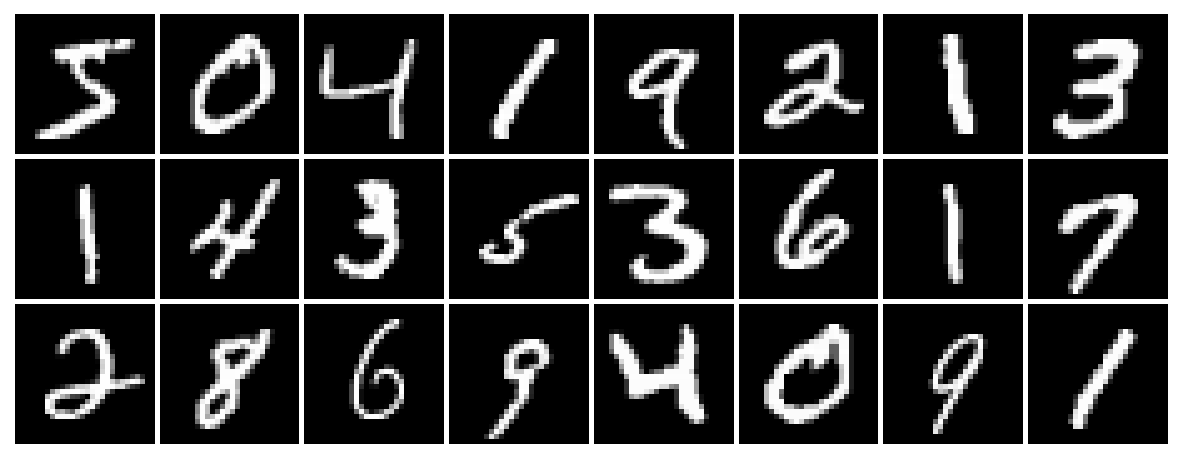

In [ ]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


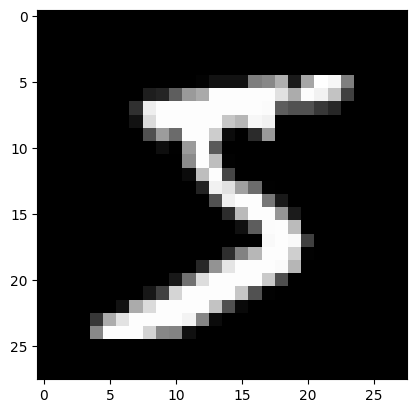

In [ ]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [ ]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [ ]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.4116, -0.0336,  0.1081, -0.3757, -0.3145,  0.3796, -0.0891,  0.1247,
         -0.1534, -0.1765],
        [ 0.2310, -0.0106, -0.0308, -0.4932,  0.1570,  0.1349,  0.3438, -0.0339,
         -0.0839, -0.1878],
        [ 0.1128, -0.0132,  0.1287, -0.3921, -0.2545,  0.2258,  0.0120,  0.2802,
         -0.2173, -0.0284],
        [ 0.0854, -0.2741, -0.1138, -0.4612, -0.2468,  0.1089,  0.0995,  0.2123,
          0.1202,  0.0484],
        [ 0.1410, -0.2989, -0.0293, -0.4058,  0.0064,  0.2767,  0.0463, -0.0730,
          0.1962, -0.0445]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [ ]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [ ]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-ipcpa3h_
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-ipcpa3h_
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=8c3febfb2da835d3f1bd65e42b8299b396c41a53c0ab57968345daeb6dc741fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pa3vrryd/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [ ]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3239, grad_fn=<NllLossBackward0>)

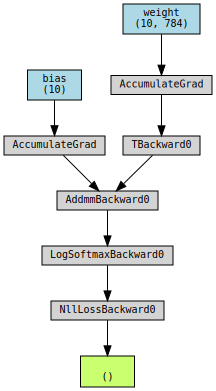

In [ ]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [ ]:
print('Final loss:', loss.item())

Final loss: 0.2652171850204468


### Visualizando gráfico de perda durante o treinamento

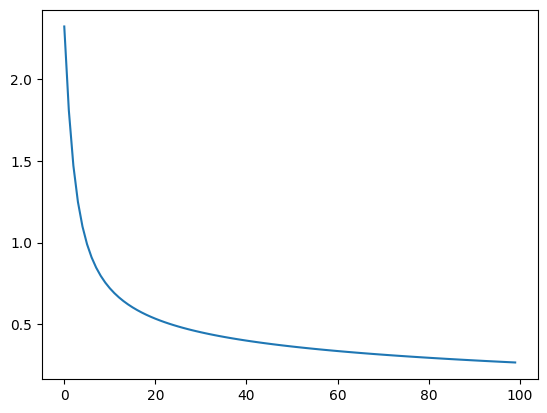

In [ ]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [ ]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.943


### Matriz de confusão com dados de treinamento e teste

In [ ]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


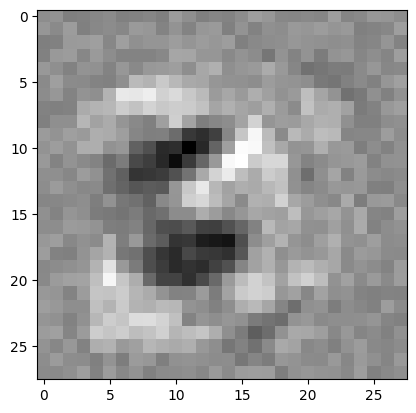

In [ ]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

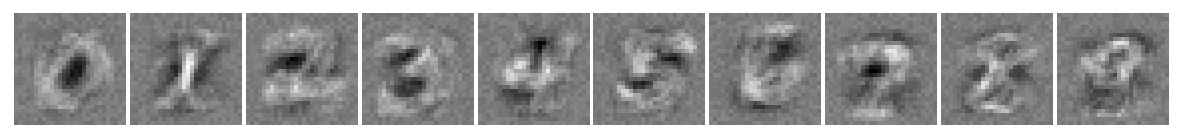

In [ ]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [ ]:
model = torch.nn.Linear(28*28, 10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

inputs = Variable(x_train.view(-1, 28 * 28))
target = Variable(y_train)

epochs = 200
losses = []

for i in range(epochs):
    outputs = model(inputs)

    loss = criterion(outputs, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f'Epoch[{i+1}/{epochs}], loss: {loss.data}, acc: {accuracy}')

Epoch[1/200], loss: 2.3120646476745605, acc: 0.093
Epoch[2/200], loss: 1.8030421733856201, acc: 0.677
Epoch[3/200], loss: 1.4638910293579102, acc: 0.782
Epoch[4/200], loss: 1.242344856262207, acc: 0.791
Epoch[5/200], loss: 1.0924878120422363, acc: 0.814
Epoch[6/200], loss: 0.9848142862319946, acc: 0.822
Epoch[7/200], loss: 0.9049319624900818, acc: 0.834
Epoch[8/200], loss: 0.8430454730987549, acc: 0.84
Epoch[9/200], loss: 0.7934384942054749, acc: 0.846
Epoch[10/200], loss: 0.7525462508201599, acc: 0.853
Epoch[11/200], loss: 0.7180988192558289, acc: 0.857
Epoch[12/200], loss: 0.6885698437690735, acc: 0.861
Epoch[13/200], loss: 0.6628894805908203, acc: 0.865
Epoch[14/200], loss: 0.6402832269668579, acc: 0.866
Epoch[15/200], loss: 0.6201764345169067, acc: 0.869
Epoch[16/200], loss: 0.6021325588226318, acc: 0.872
Epoch[17/200], loss: 0.5858144760131836, acc: 0.875
Epoch[18/200], loss: 0.5709565877914429, acc: 0.878
Epoch[19/200], loss: 0.557347297668457, acc: 0.881
Epoch[20/200], loss: 0.5

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Epoch[1/200], loss: 2.2902541160583496, acc: 0.141


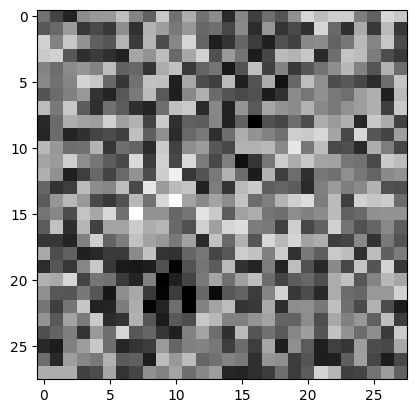

Epoch[2/200], loss: 1.7835692167282104, acc: 0.663


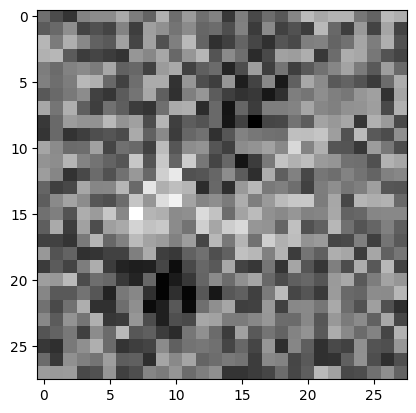

Epoch[3/200], loss: 1.4508956670761108, acc: 0.756


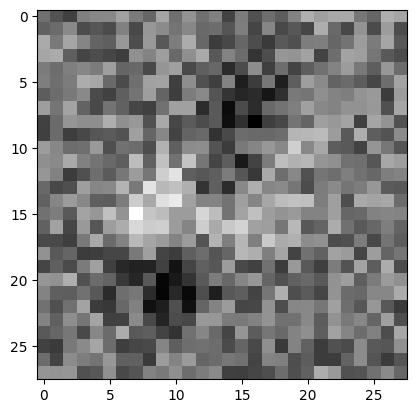

Epoch[4/200], loss: 1.2324676513671875, acc: 0.802


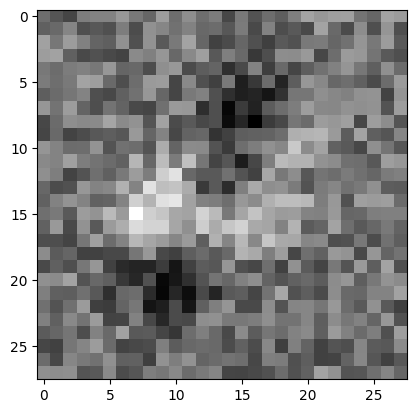

Epoch[5/200], loss: 1.085376501083374, acc: 0.811


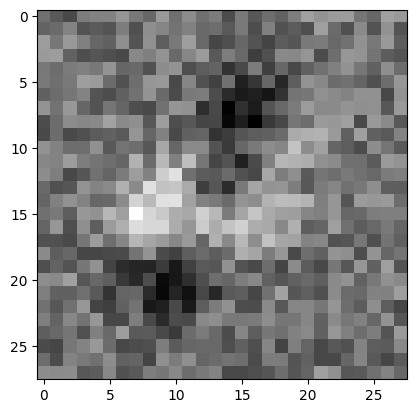

Epoch[6/200], loss: 0.9791194796562195, acc: 0.832


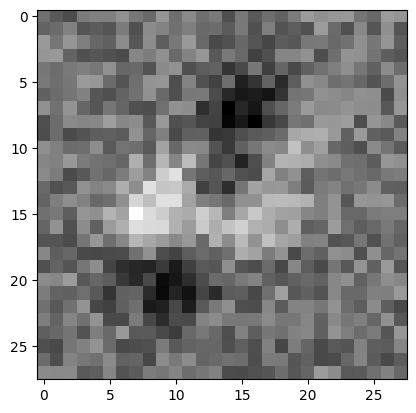

Epoch[7/200], loss: 0.899978518486023, acc: 0.832


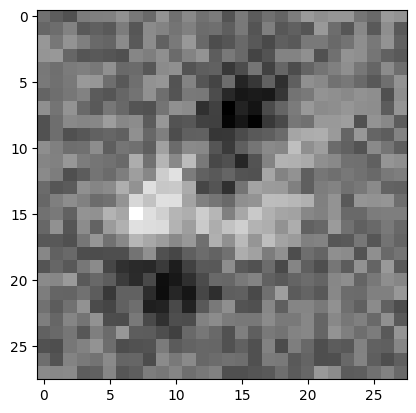

Epoch[8/200], loss: 0.8384246826171875, acc: 0.845


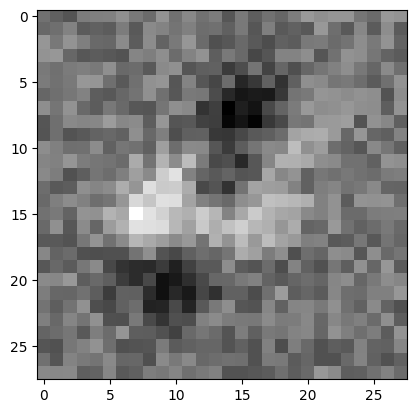

Epoch[9/200], loss: 0.7891578078269958, acc: 0.848


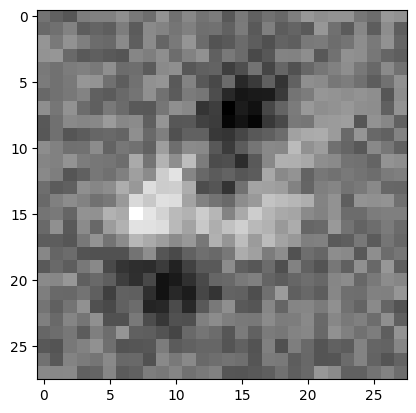

Epoch[10/200], loss: 0.7485945820808411, acc: 0.853


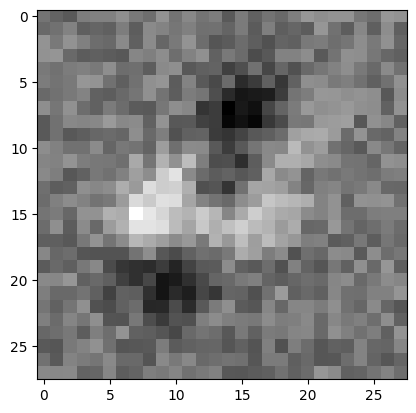

Epoch[11/200], loss: 0.7144486308097839, acc: 0.856


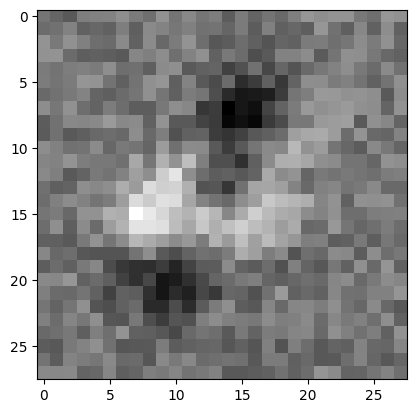

Epoch[12/200], loss: 0.6851874589920044, acc: 0.858


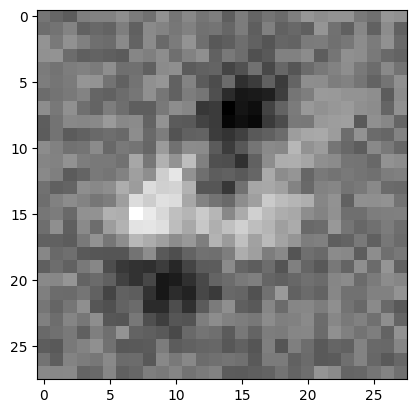

Epoch[13/200], loss: 0.6597433090209961, acc: 0.864


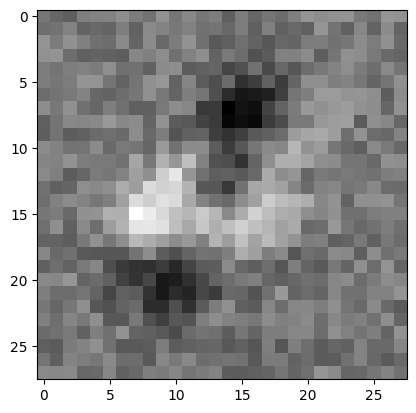

Epoch[14/200], loss: 0.6373470425605774, acc: 0.865


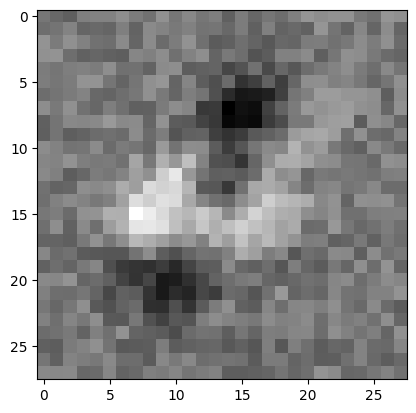

Epoch[15/200], loss: 0.6174281239509583, acc: 0.866


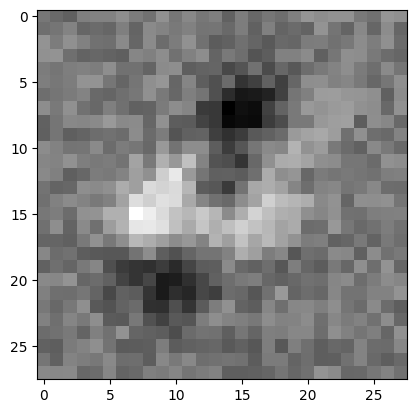

Epoch[16/200], loss: 0.5995537638664246, acc: 0.868


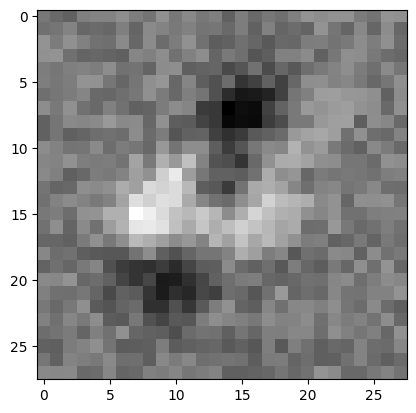

Epoch[17/200], loss: 0.5833893418312073, acc: 0.874


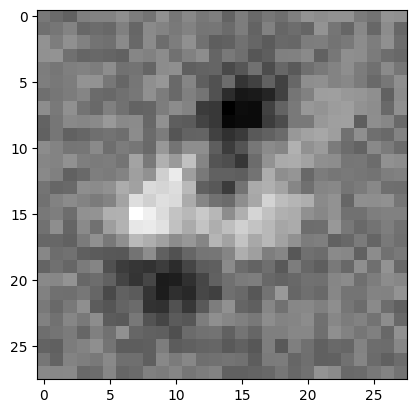

Epoch[18/200], loss: 0.5686715245246887, acc: 0.876


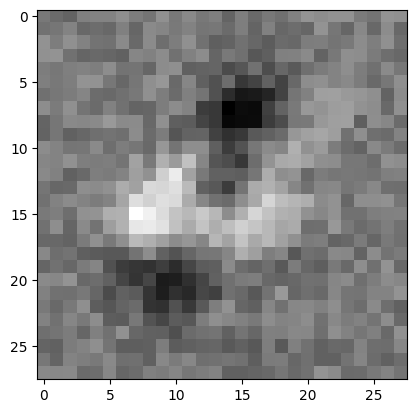

Epoch[19/200], loss: 0.5551902651786804, acc: 0.879


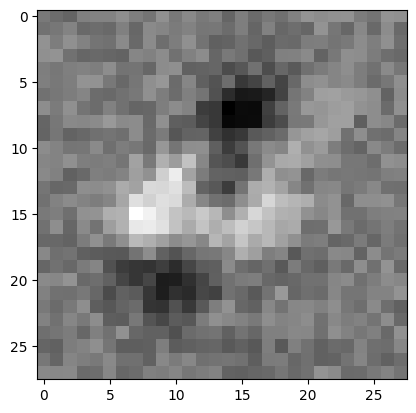

Epoch[20/200], loss: 0.5427756905555725, acc: 0.88


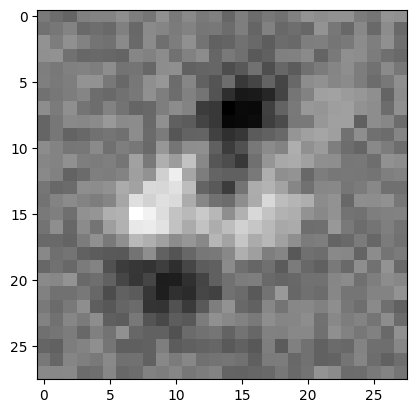

Epoch[21/200], loss: 0.531288743019104, acc: 0.882


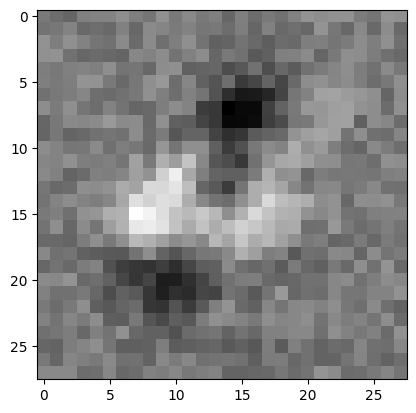

Epoch[22/200], loss: 0.5206146836280823, acc: 0.882


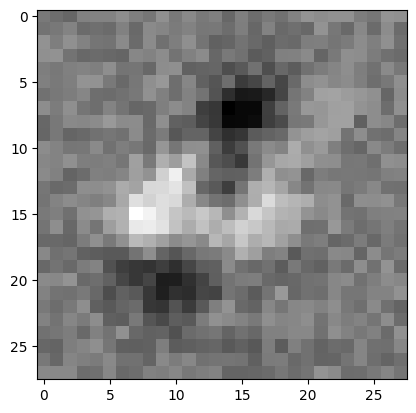

Epoch[23/200], loss: 0.5106573700904846, acc: 0.883


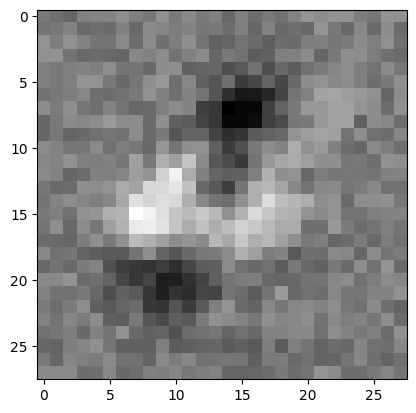

Epoch[24/200], loss: 0.5013360977172852, acc: 0.884


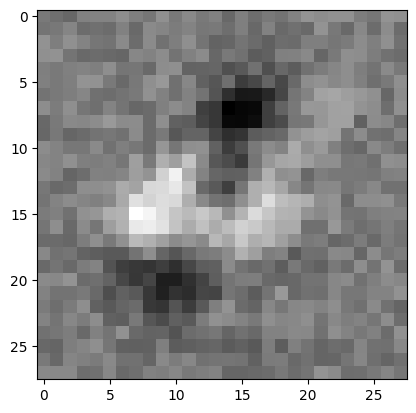

Epoch[25/200], loss: 0.4925822615623474, acc: 0.884


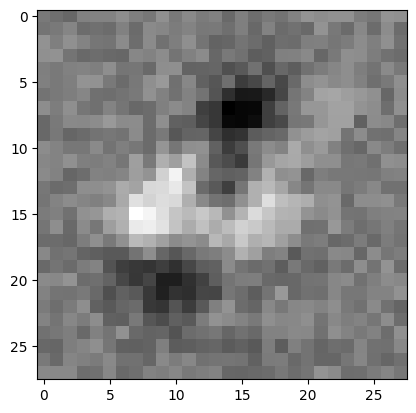

Epoch[26/200], loss: 0.48433732986450195, acc: 0.887


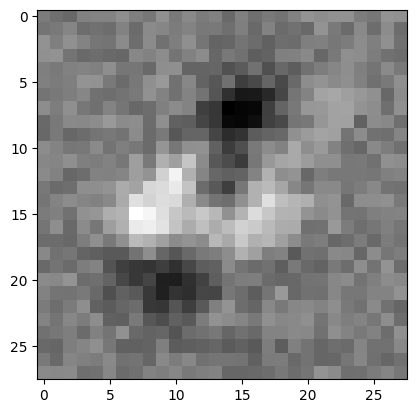

Epoch[27/200], loss: 0.47655078768730164, acc: 0.892


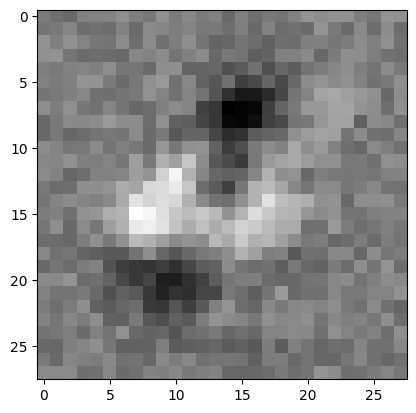

Epoch[28/200], loss: 0.4691789448261261, acc: 0.896


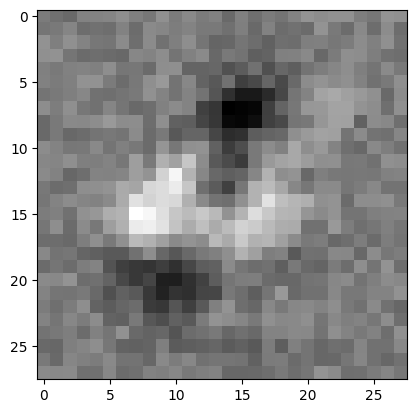

Epoch[29/200], loss: 0.4621839225292206, acc: 0.898


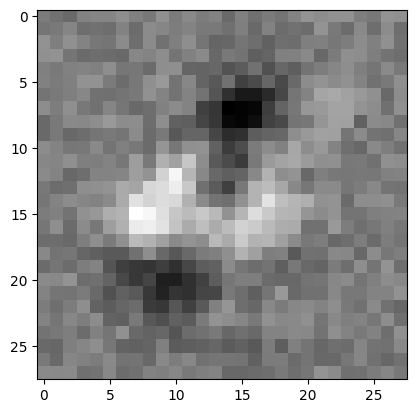

Epoch[30/200], loss: 0.45553234219551086, acc: 0.896


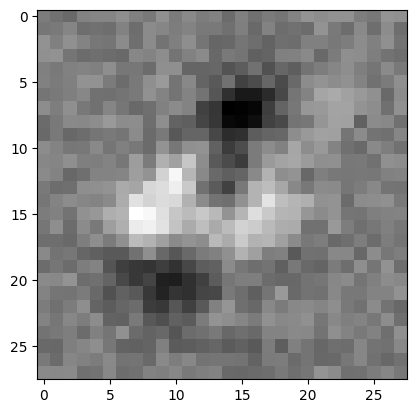

Epoch[31/200], loss: 0.44919484853744507, acc: 0.898


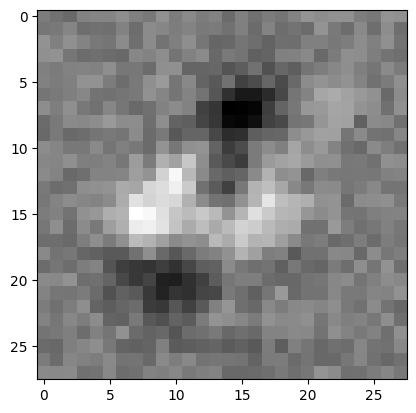

Epoch[32/200], loss: 0.443145751953125, acc: 0.899


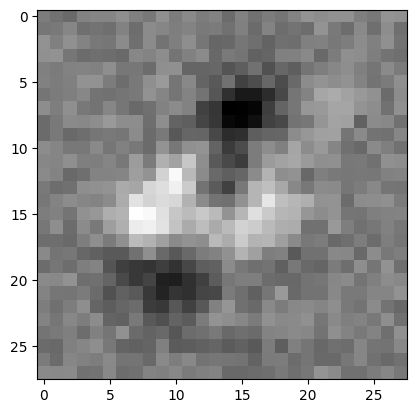

Epoch[33/200], loss: 0.4373619854450226, acc: 0.9


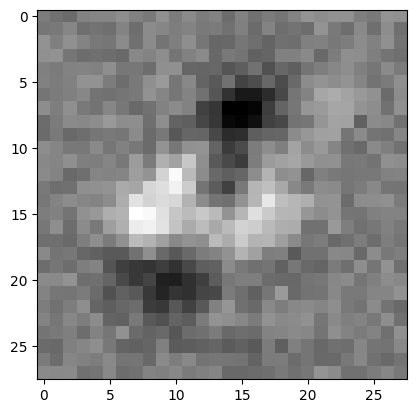

Epoch[34/200], loss: 0.4318230152130127, acc: 0.9


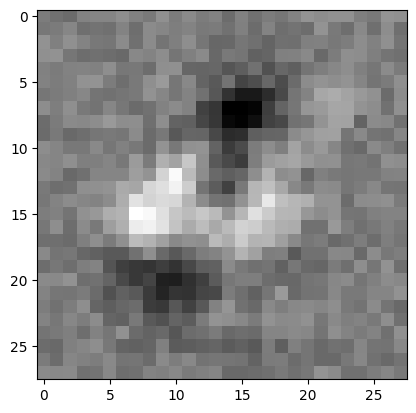

Epoch[35/200], loss: 0.4265107810497284, acc: 0.901


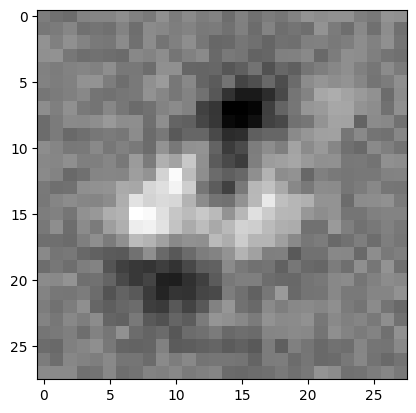

Epoch[36/200], loss: 0.42140868306159973, acc: 0.902


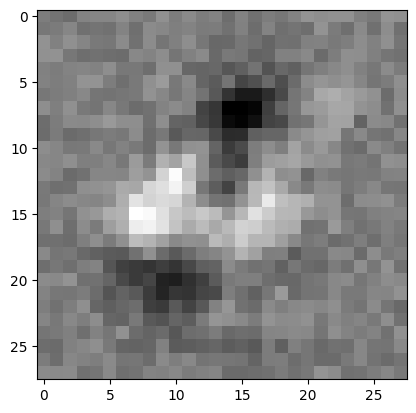

Epoch[37/200], loss: 0.41650205850601196, acc: 0.903


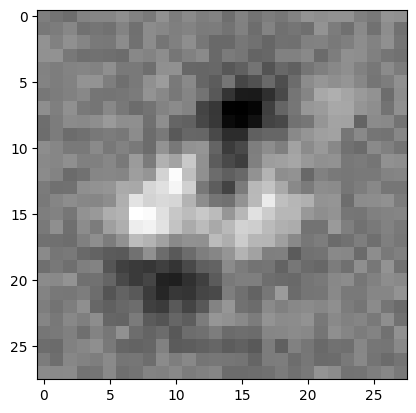

Epoch[38/200], loss: 0.41177746653556824, acc: 0.904


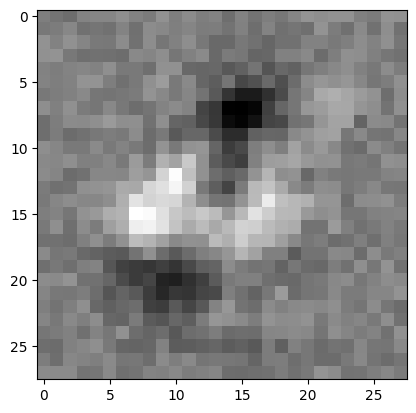

Epoch[39/200], loss: 0.4072228670120239, acc: 0.907


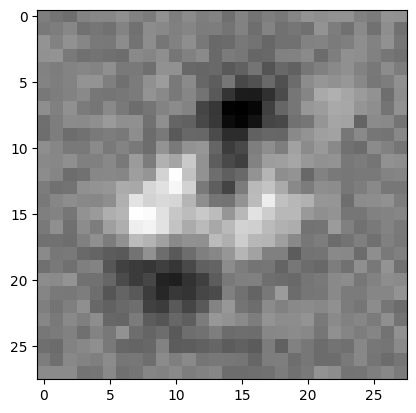

Epoch[40/200], loss: 0.40282735228538513, acc: 0.909


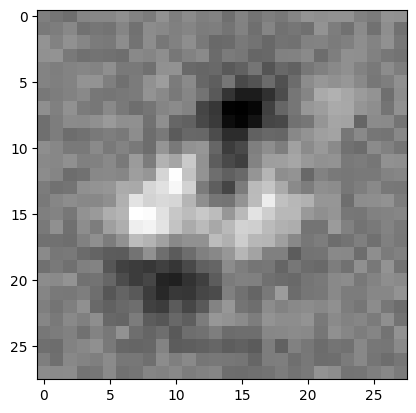

Epoch[41/200], loss: 0.3985808789730072, acc: 0.909


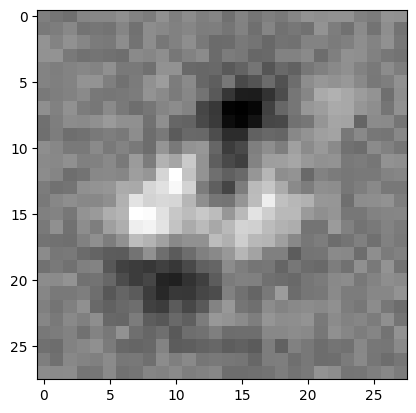

Epoch[42/200], loss: 0.3944742679595947, acc: 0.909


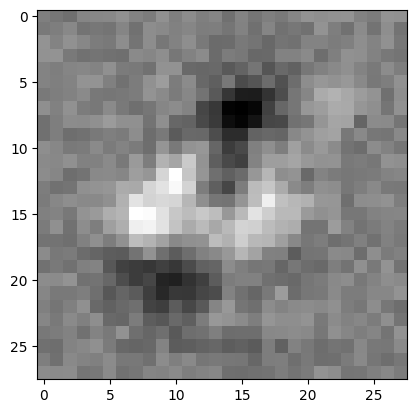

Epoch[43/200], loss: 0.3904993236064911, acc: 0.909


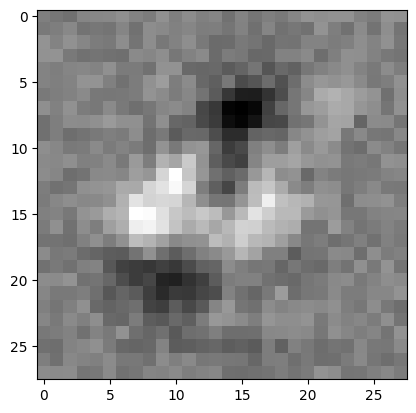

Epoch[44/200], loss: 0.3866482675075531, acc: 0.909


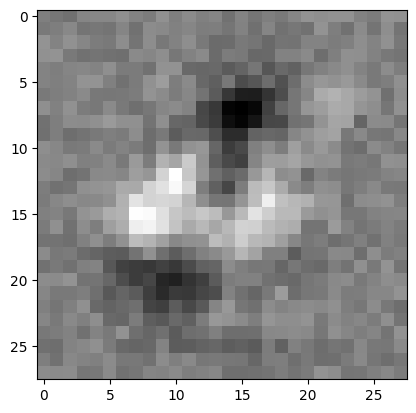

Epoch[45/200], loss: 0.38291409611701965, acc: 0.912


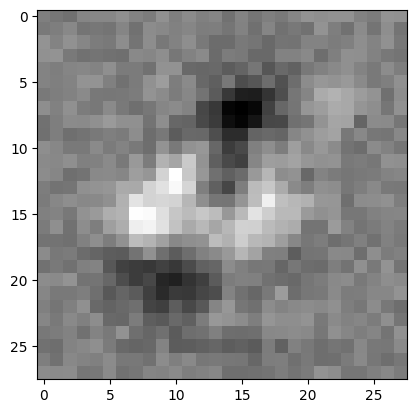

Epoch[46/200], loss: 0.3792904019355774, acc: 0.913


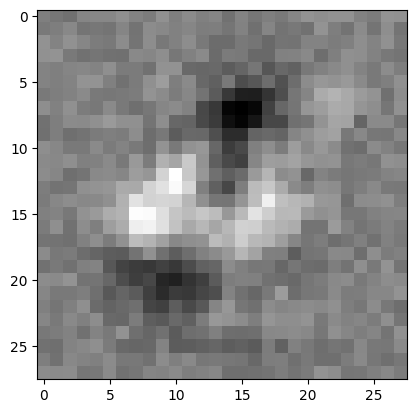

Epoch[47/200], loss: 0.3757711350917816, acc: 0.915


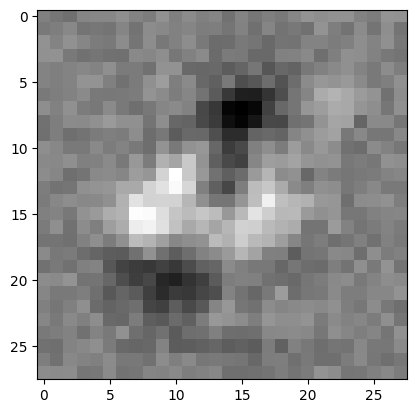

Epoch[48/200], loss: 0.372350811958313, acc: 0.917


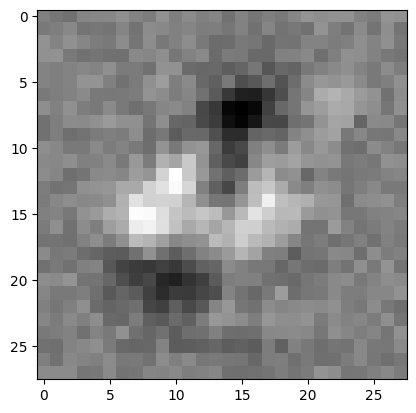

Epoch[49/200], loss: 0.3690243661403656, acc: 0.918


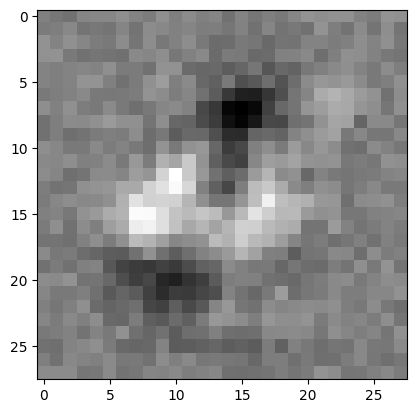

Epoch[50/200], loss: 0.36578691005706787, acc: 0.919


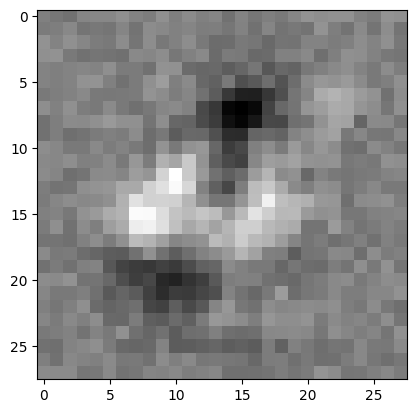

Epoch[51/200], loss: 0.3626341223716736, acc: 0.919


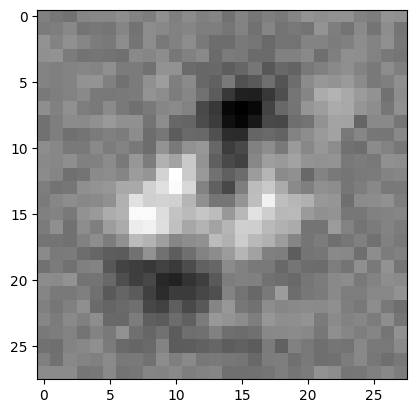

Epoch[52/200], loss: 0.3595620095729828, acc: 0.919


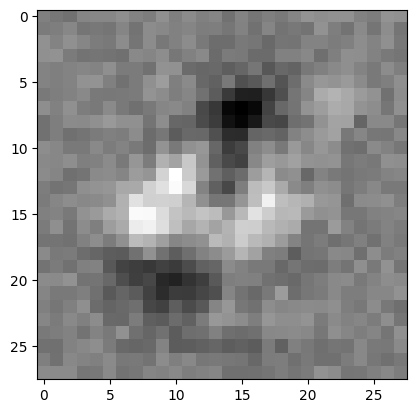

Epoch[53/200], loss: 0.3565666079521179, acc: 0.919


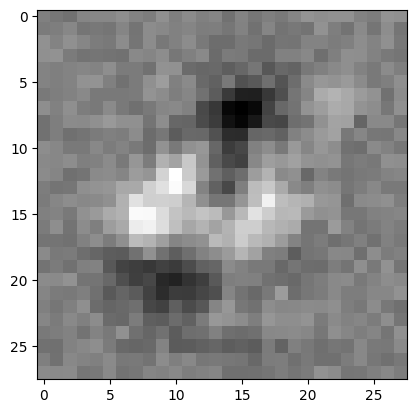

Epoch[54/200], loss: 0.353644460439682, acc: 0.92


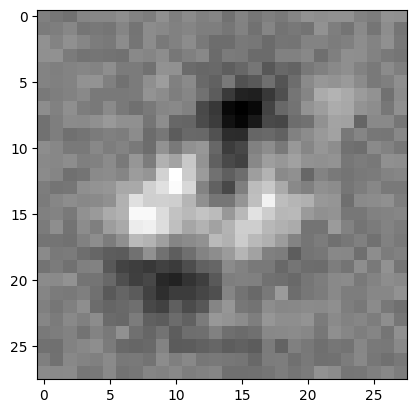

Epoch[55/200], loss: 0.3507922291755676, acc: 0.921


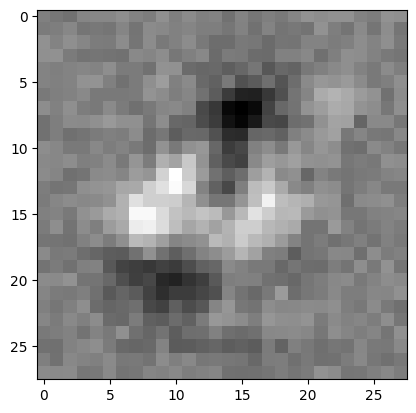

Epoch[56/200], loss: 0.3480067253112793, acc: 0.922


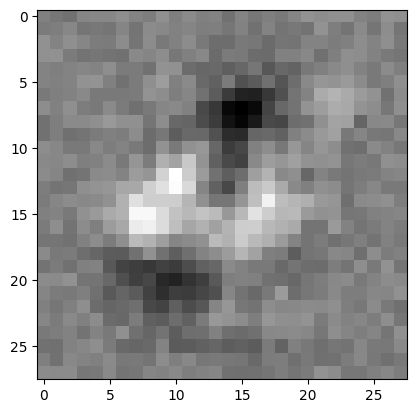

Epoch[57/200], loss: 0.3452850580215454, acc: 0.924


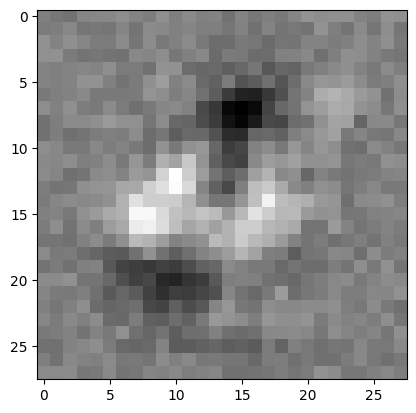

Epoch[58/200], loss: 0.3426245450973511, acc: 0.924


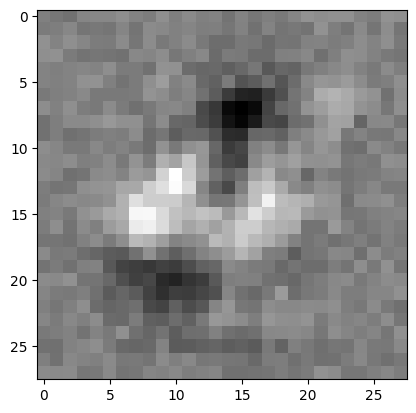

Epoch[59/200], loss: 0.34002259373664856, acc: 0.924


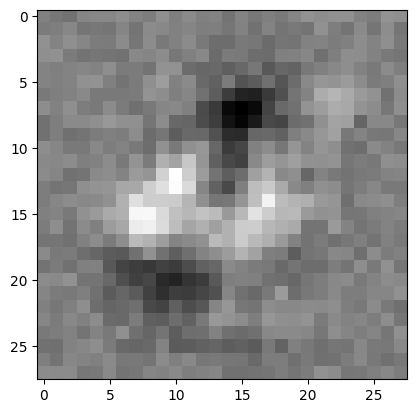

Epoch[60/200], loss: 0.33747684955596924, acc: 0.924


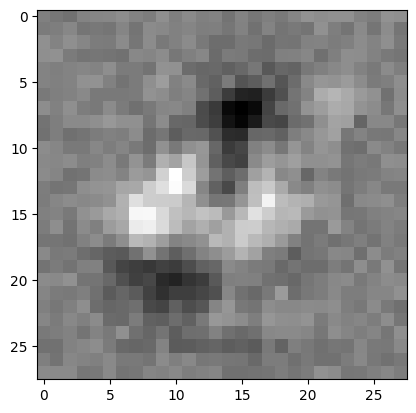

Epoch[61/200], loss: 0.33498483896255493, acc: 0.925


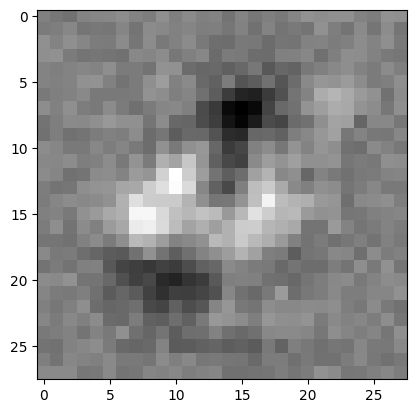

Epoch[62/200], loss: 0.3325446546077728, acc: 0.926


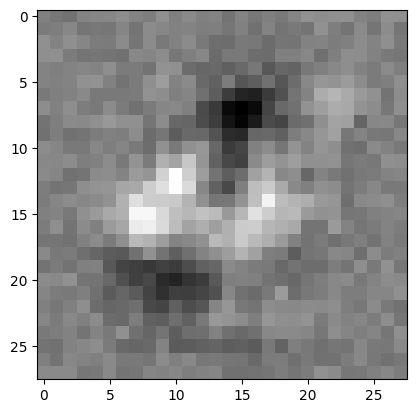

Epoch[63/200], loss: 0.3301541805267334, acc: 0.927


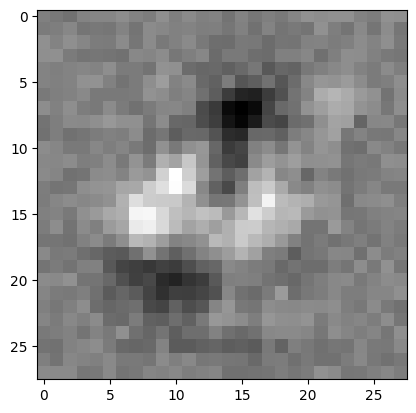

Epoch[64/200], loss: 0.32781150937080383, acc: 0.928


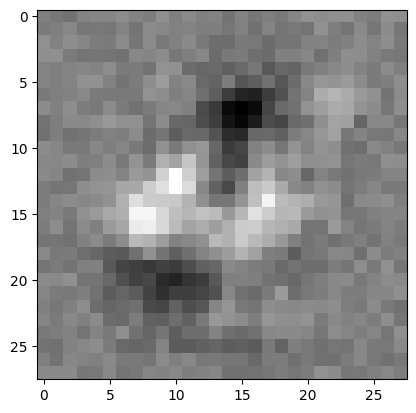

Epoch[65/200], loss: 0.32551485300064087, acc: 0.928


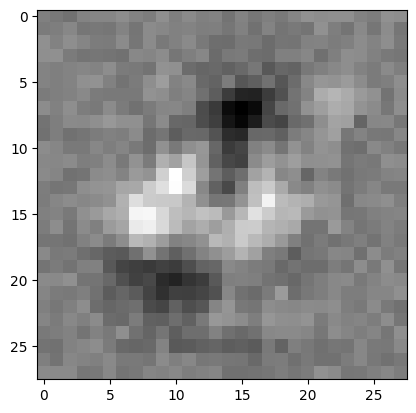

Epoch[66/200], loss: 0.323262482881546, acc: 0.928


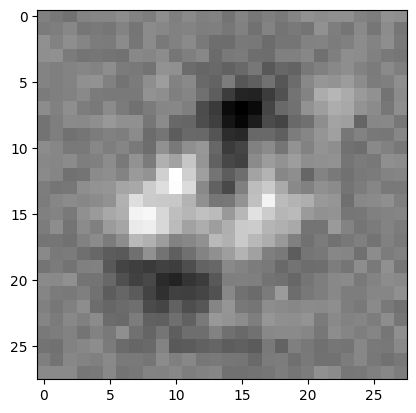

Epoch[67/200], loss: 0.3210528790950775, acc: 0.928


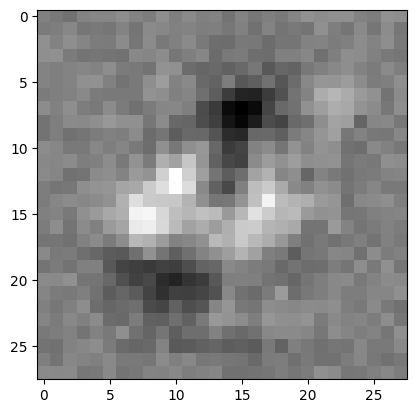

Epoch[68/200], loss: 0.31888440251350403, acc: 0.928


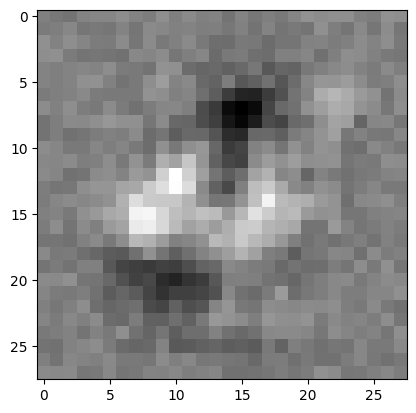

Epoch[69/200], loss: 0.3167556822299957, acc: 0.928


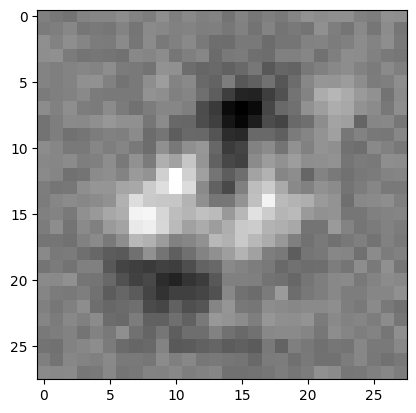

Epoch[70/200], loss: 0.314665287733078, acc: 0.928


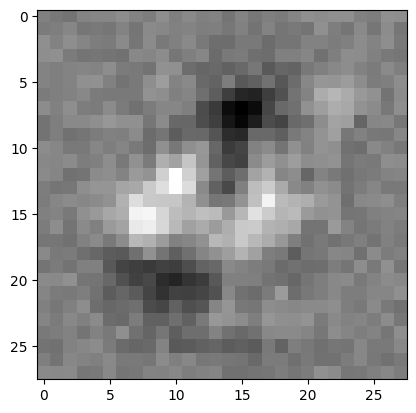

Epoch[71/200], loss: 0.31261196732521057, acc: 0.928


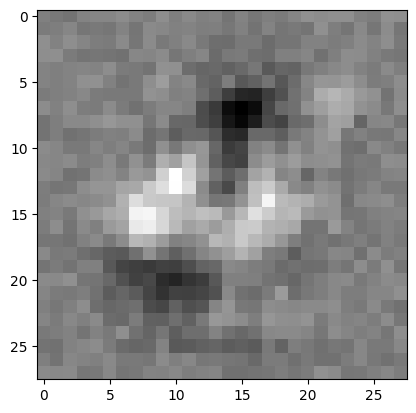

Epoch[72/200], loss: 0.3105944097042084, acc: 0.929


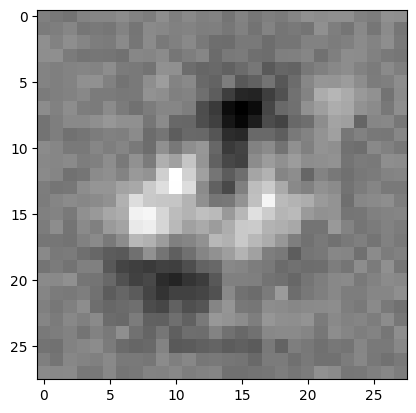

Epoch[73/200], loss: 0.30861154198646545, acc: 0.93


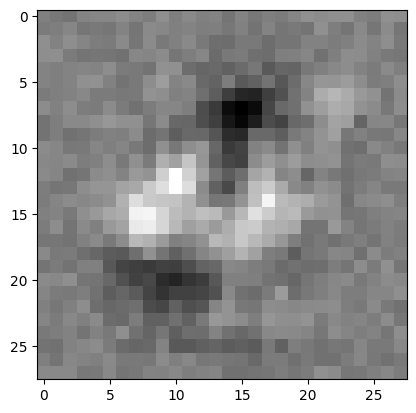

Epoch[74/200], loss: 0.3066621720790863, acc: 0.93


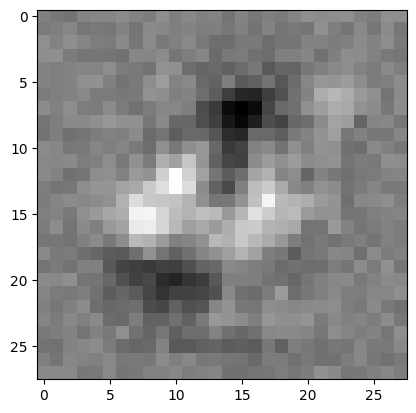

Epoch[75/200], loss: 0.30474522709846497, acc: 0.93


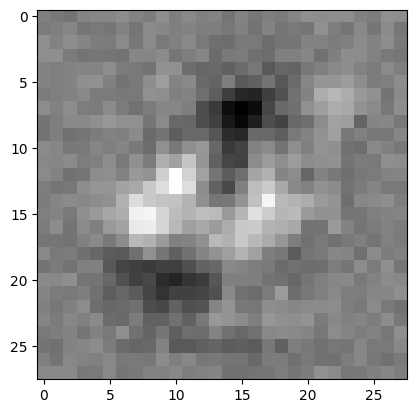

Epoch[76/200], loss: 0.30285972356796265, acc: 0.931


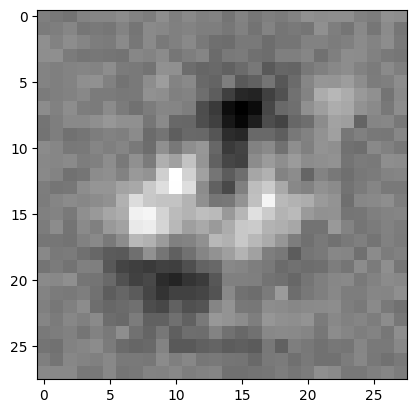

Epoch[77/200], loss: 0.30100464820861816, acc: 0.932


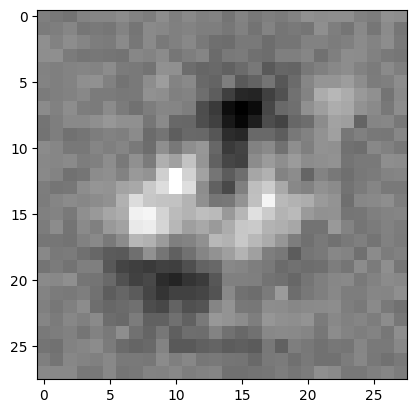

Epoch[78/200], loss: 0.2991790771484375, acc: 0.932


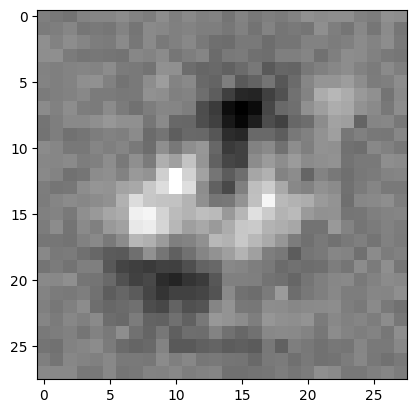

Epoch[79/200], loss: 0.2973821461200714, acc: 0.932


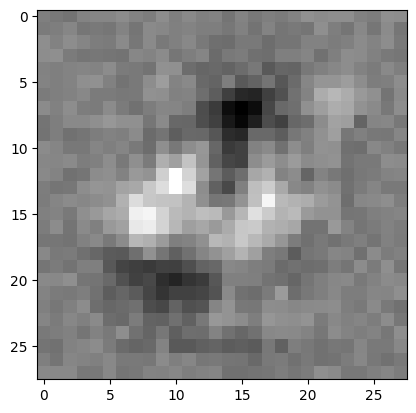

Epoch[80/200], loss: 0.2956129312515259, acc: 0.932


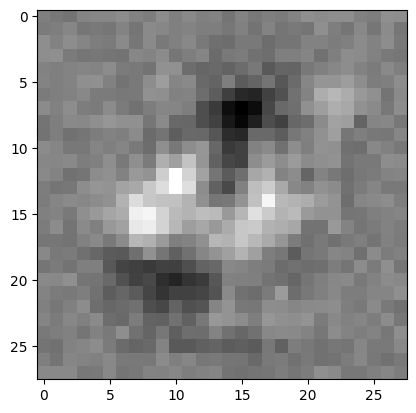

Epoch[81/200], loss: 0.293870747089386, acc: 0.933


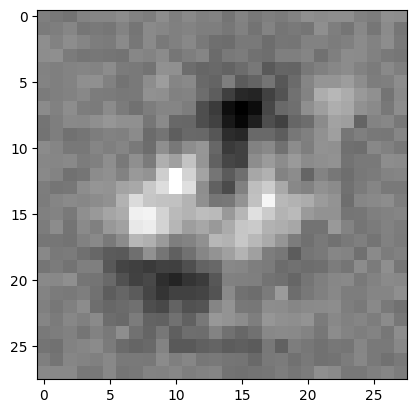

Epoch[82/200], loss: 0.29215481877326965, acc: 0.933


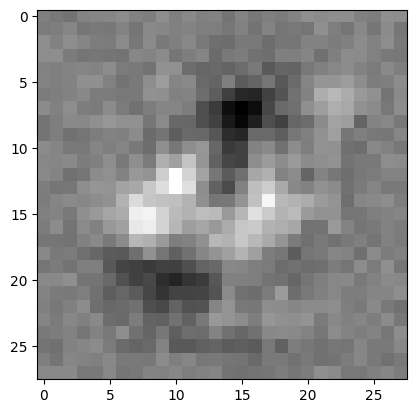

Epoch[83/200], loss: 0.29046428203582764, acc: 0.933


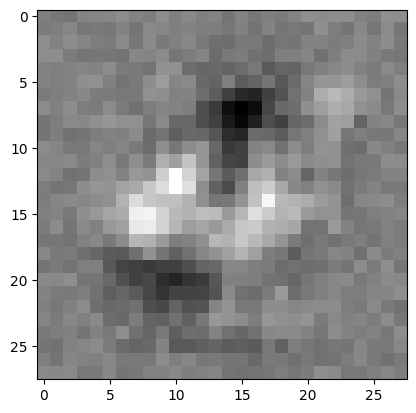

Epoch[84/200], loss: 0.288798451423645, acc: 0.933


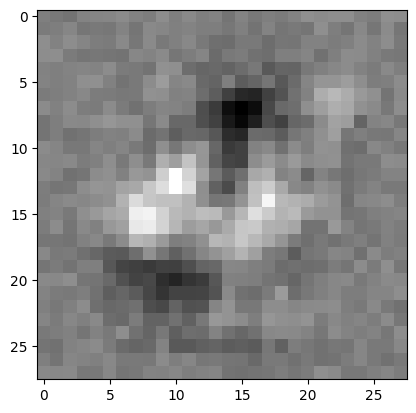

Epoch[85/200], loss: 0.28715676069259644, acc: 0.933


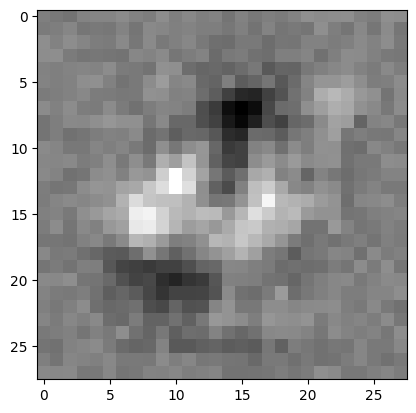

Epoch[86/200], loss: 0.2855384051799774, acc: 0.933


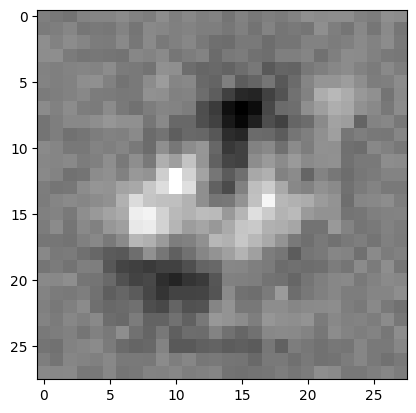

Epoch[87/200], loss: 0.2839428186416626, acc: 0.933


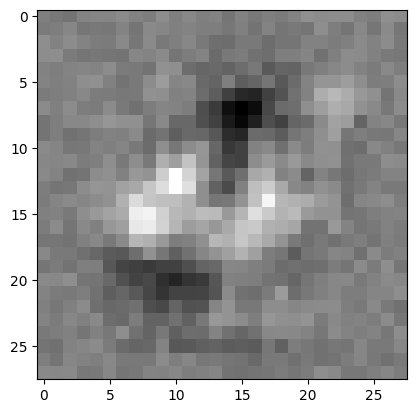

Epoch[88/200], loss: 0.28236937522888184, acc: 0.933


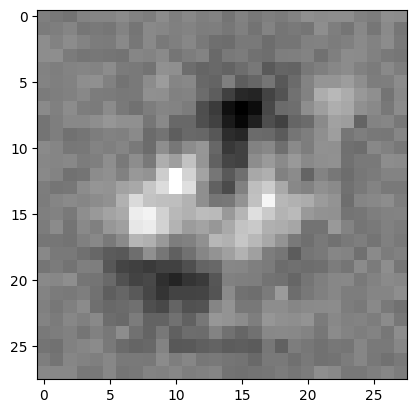

Epoch[89/200], loss: 0.28081756830215454, acc: 0.933


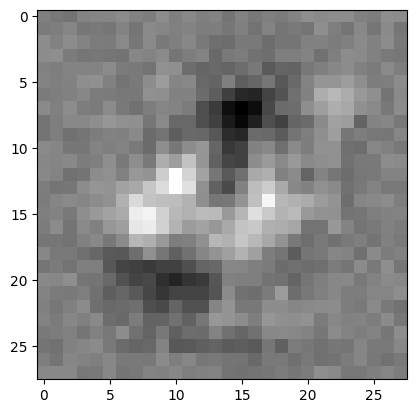

Epoch[90/200], loss: 0.27928680181503296, acc: 0.934


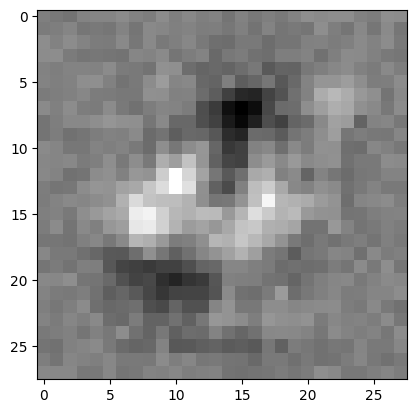

Epoch[91/200], loss: 0.2777765095233917, acc: 0.934


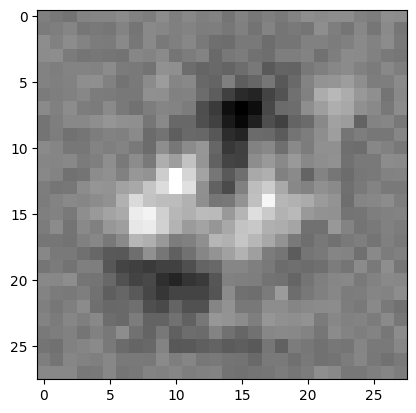

Epoch[92/200], loss: 0.27628615498542786, acc: 0.934


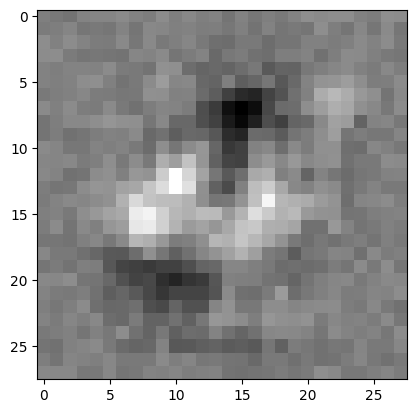

Epoch[93/200], loss: 0.2748153805732727, acc: 0.934


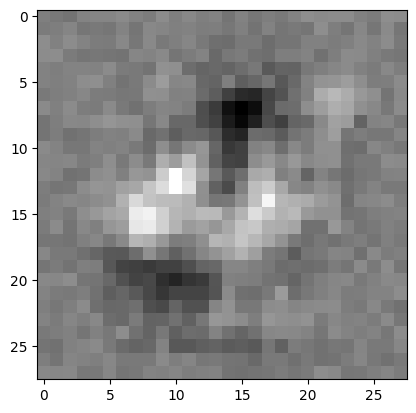

Epoch[94/200], loss: 0.27336353063583374, acc: 0.934


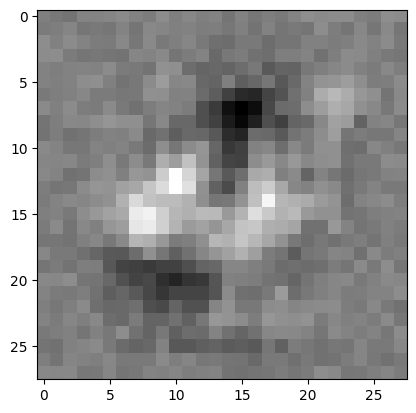

Epoch[95/200], loss: 0.2719302475452423, acc: 0.935


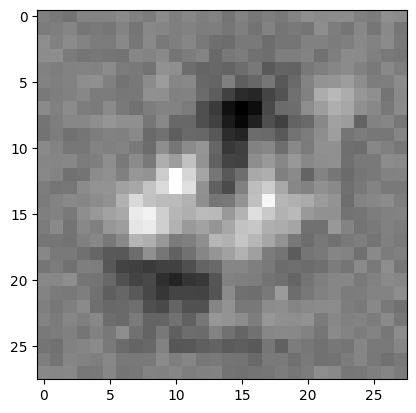

Epoch[96/200], loss: 0.2705150544643402, acc: 0.936


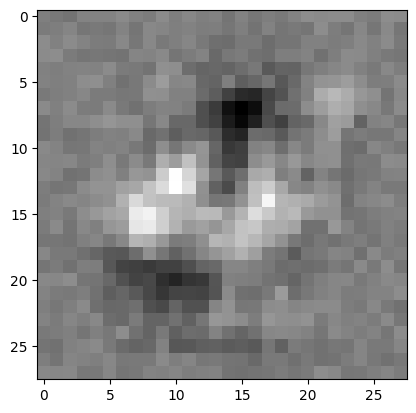

Epoch[97/200], loss: 0.269117534160614, acc: 0.936


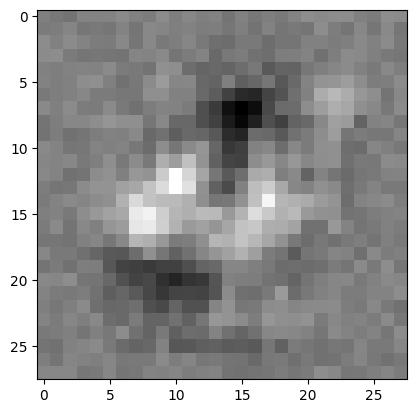

Epoch[98/200], loss: 0.2677372395992279, acc: 0.937


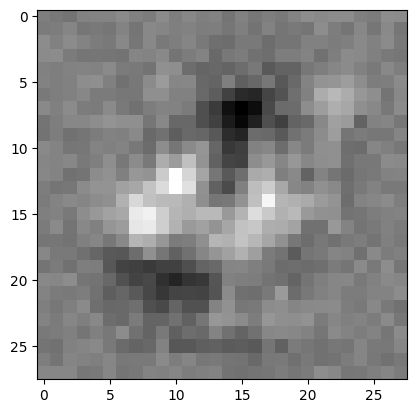

Epoch[99/200], loss: 0.266373872756958, acc: 0.939


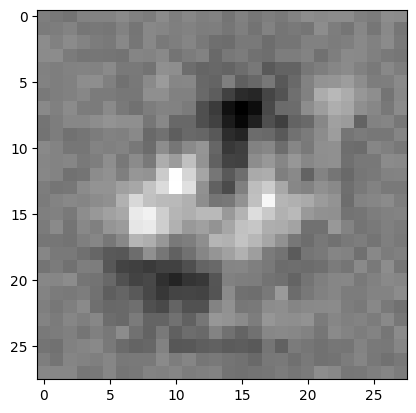

Epoch[100/200], loss: 0.2650269865989685, acc: 0.94


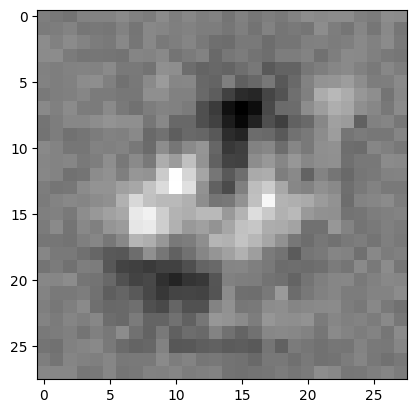

Epoch[101/200], loss: 0.2636961340904236, acc: 0.94


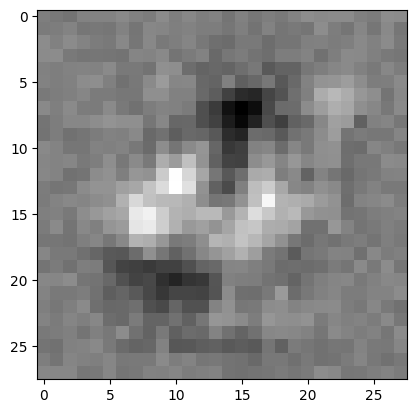

Epoch[102/200], loss: 0.26238110661506653, acc: 0.94


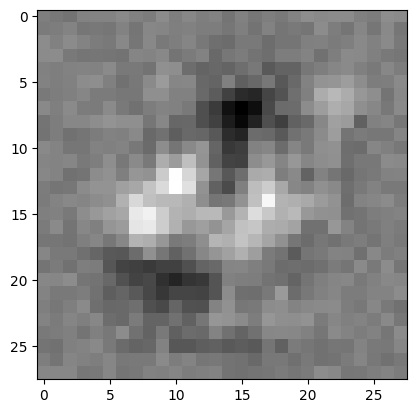

Epoch[103/200], loss: 0.26108139753341675, acc: 0.94


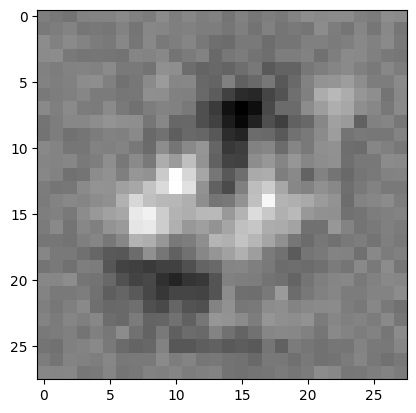

Epoch[104/200], loss: 0.25979679822921753, acc: 0.942


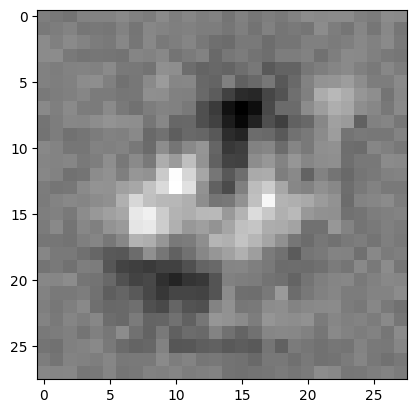

Epoch[105/200], loss: 0.25852692127227783, acc: 0.942


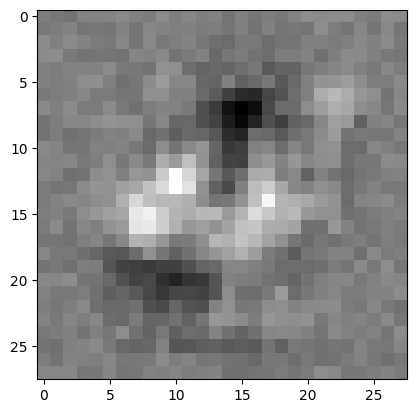

Epoch[106/200], loss: 0.2572714686393738, acc: 0.942


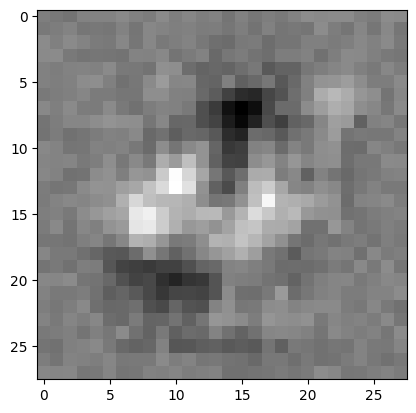

Epoch[107/200], loss: 0.2560301125049591, acc: 0.942


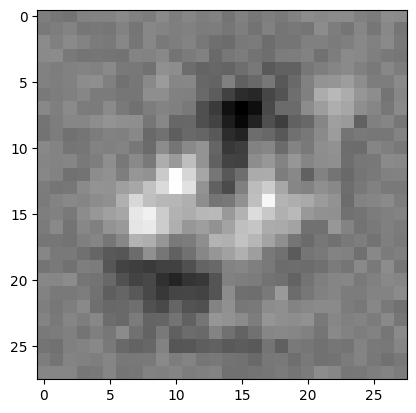

Epoch[108/200], loss: 0.2548026442527771, acc: 0.944


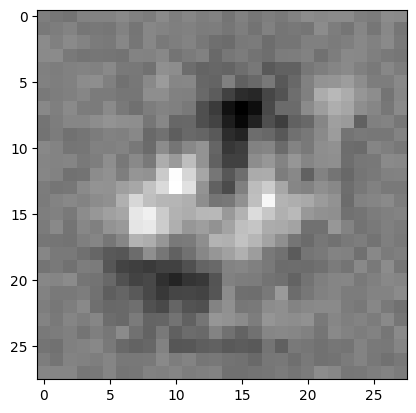

Epoch[109/200], loss: 0.2535886764526367, acc: 0.945


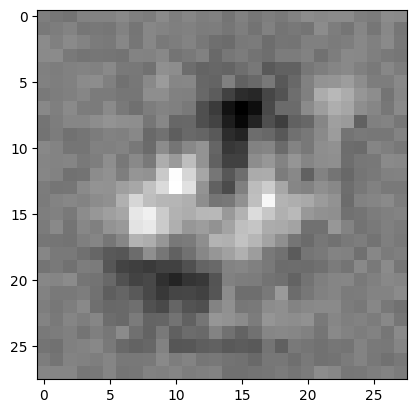

Epoch[110/200], loss: 0.25238797068595886, acc: 0.946


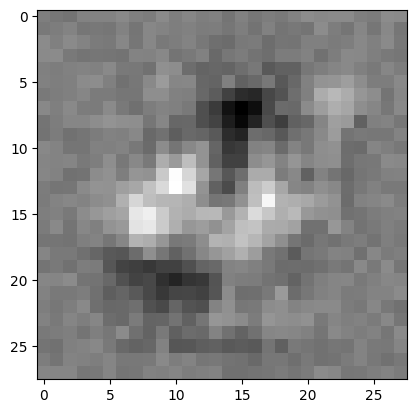

Epoch[111/200], loss: 0.25120025873184204, acc: 0.947


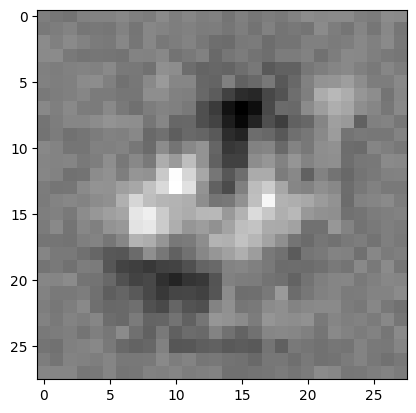

Epoch[112/200], loss: 0.25002530217170715, acc: 0.947


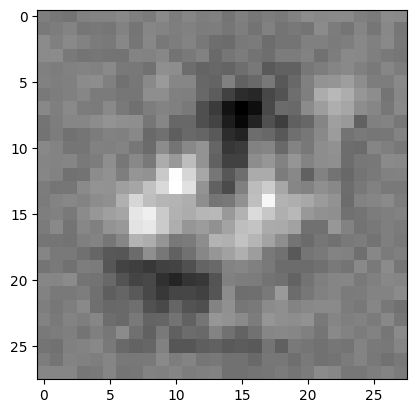

Epoch[113/200], loss: 0.2488628327846527, acc: 0.947


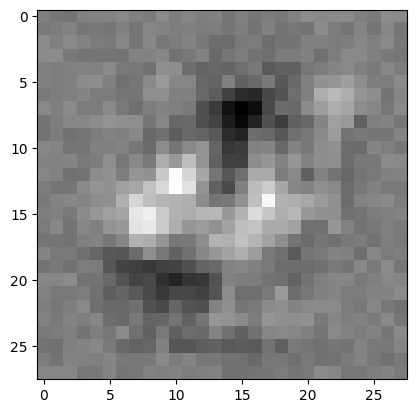

Epoch[114/200], loss: 0.24771255254745483, acc: 0.947


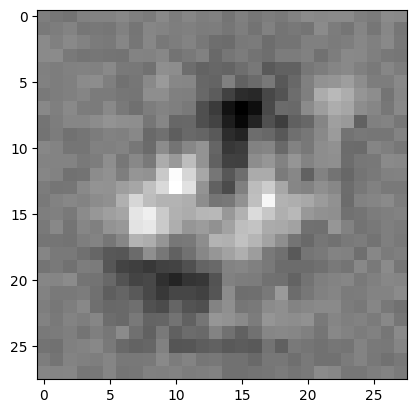

Epoch[115/200], loss: 0.24657434225082397, acc: 0.947


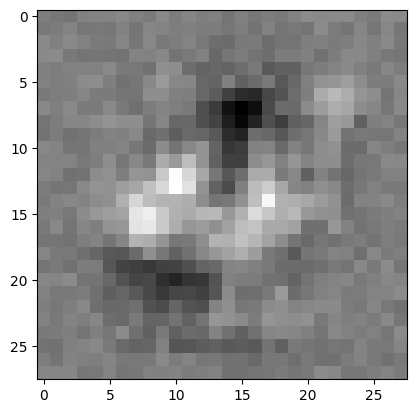

Epoch[116/200], loss: 0.24544785916805267, acc: 0.947


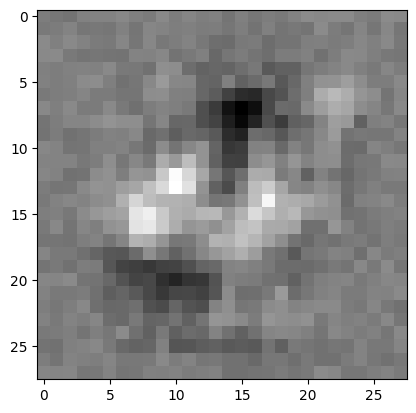

Epoch[117/200], loss: 0.2443329393863678, acc: 0.947


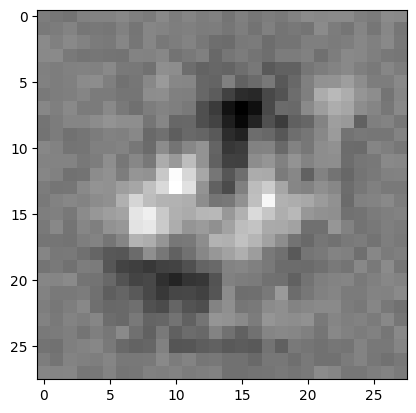

Epoch[118/200], loss: 0.24322934448719025, acc: 0.947


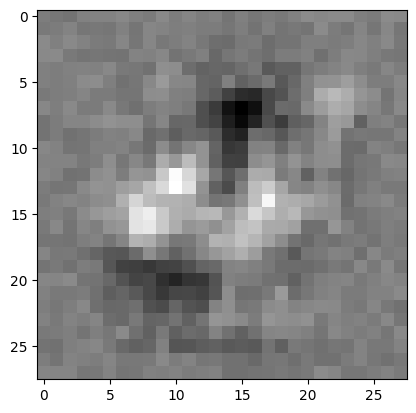

Epoch[119/200], loss: 0.2421369105577469, acc: 0.947


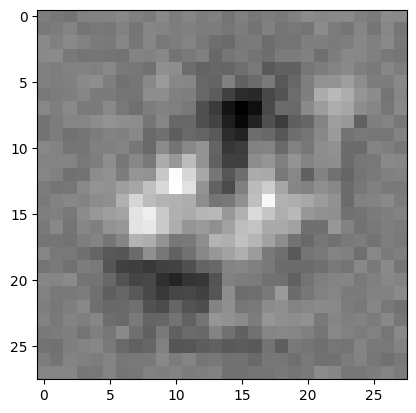

Epoch[120/200], loss: 0.24105535447597504, acc: 0.949


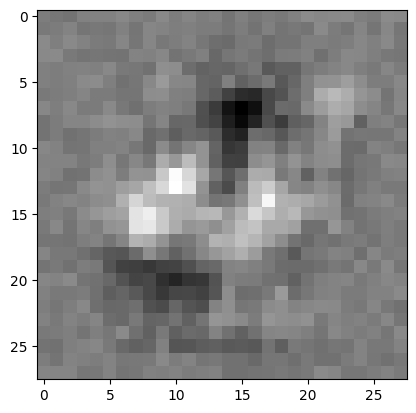

Epoch[121/200], loss: 0.23998451232910156, acc: 0.949


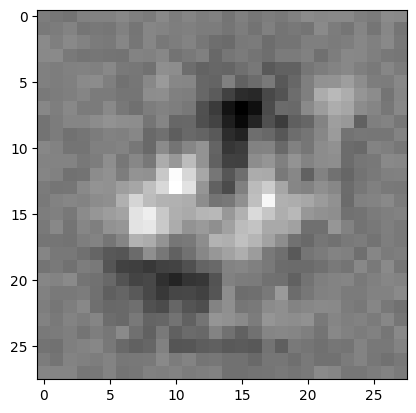

Epoch[122/200], loss: 0.23892423510551453, acc: 0.95


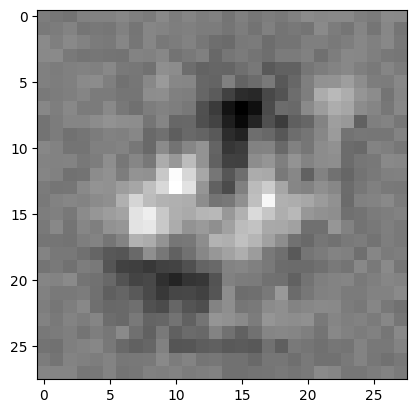

Epoch[123/200], loss: 0.23787425458431244, acc: 0.951


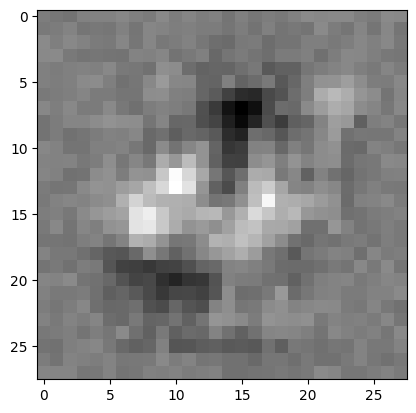

Epoch[124/200], loss: 0.23683445155620575, acc: 0.951


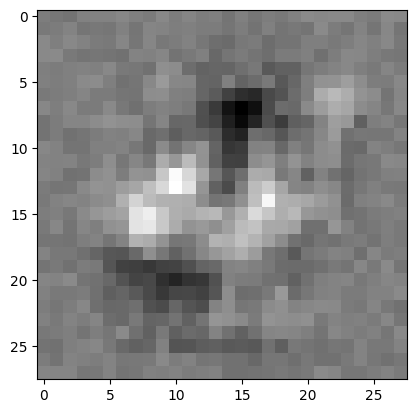

Epoch[125/200], loss: 0.23580460250377655, acc: 0.951


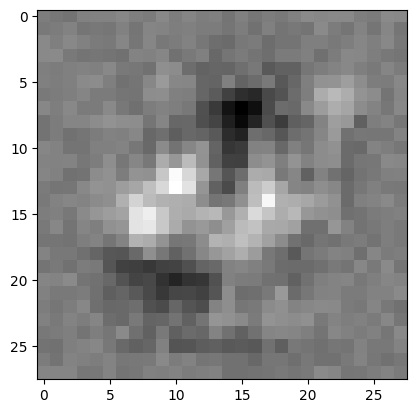

Epoch[126/200], loss: 0.2347845733165741, acc: 0.952


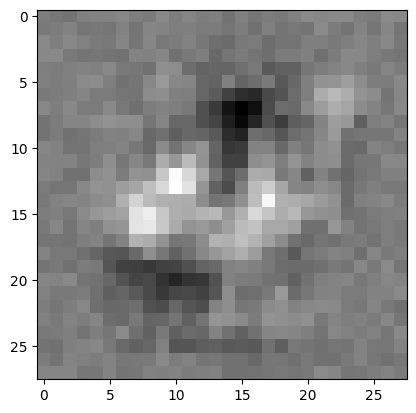

Epoch[127/200], loss: 0.23377418518066406, acc: 0.952


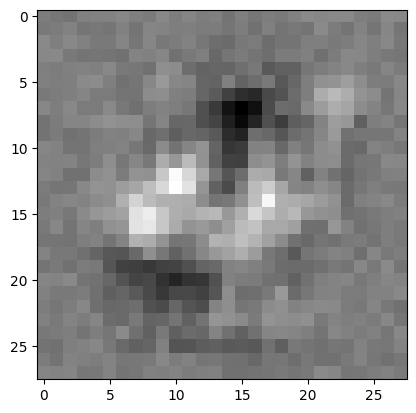

Epoch[128/200], loss: 0.23277324438095093, acc: 0.952


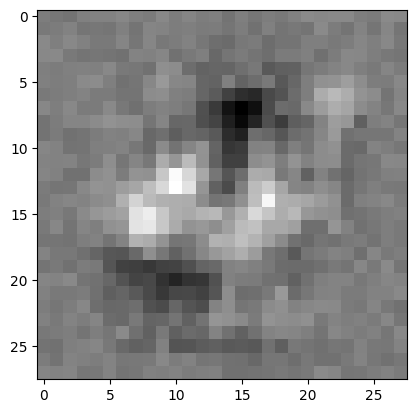

Epoch[129/200], loss: 0.23178160190582275, acc: 0.952


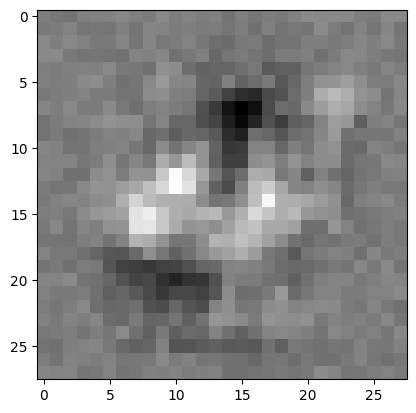

Epoch[130/200], loss: 0.2307991236448288, acc: 0.953


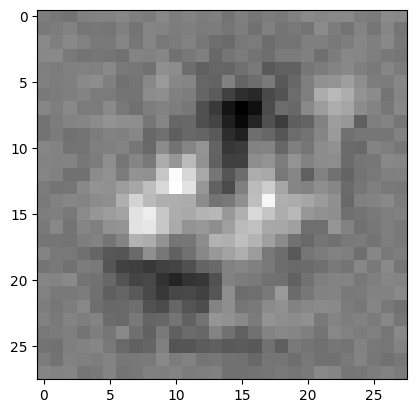

Epoch[131/200], loss: 0.22982560098171234, acc: 0.954


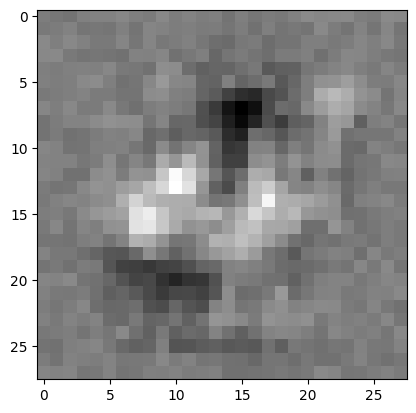

Epoch[132/200], loss: 0.2288609892129898, acc: 0.954


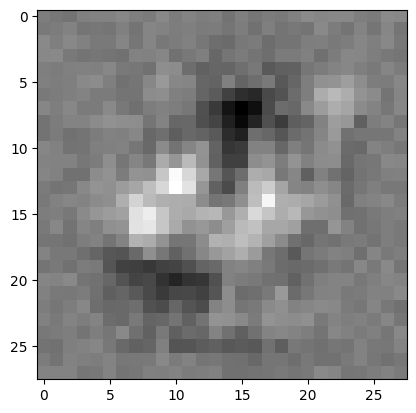

Epoch[133/200], loss: 0.2279050499200821, acc: 0.954


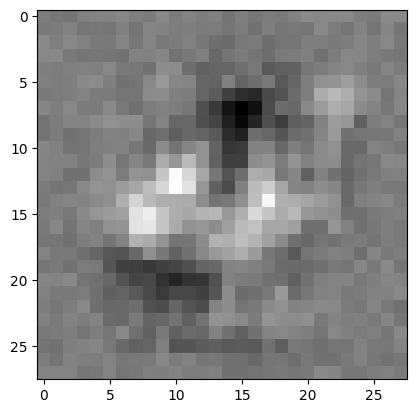

Epoch[134/200], loss: 0.22695772349834442, acc: 0.954


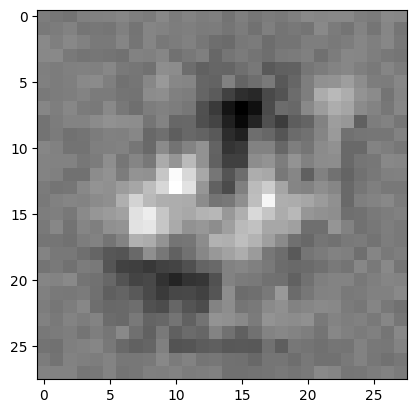

Epoch[135/200], loss: 0.22601880133152008, acc: 0.955


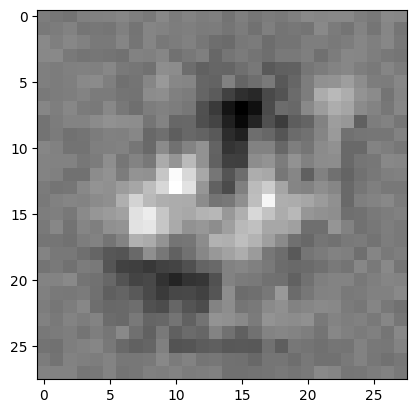

Epoch[136/200], loss: 0.22508816421031952, acc: 0.955


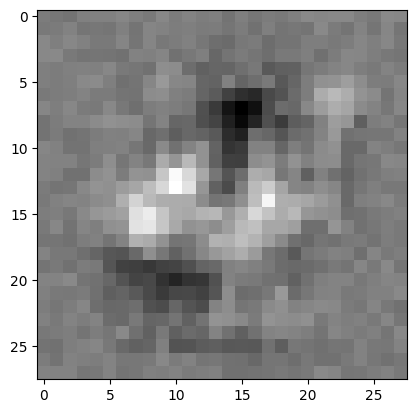

Epoch[137/200], loss: 0.224165678024292, acc: 0.956


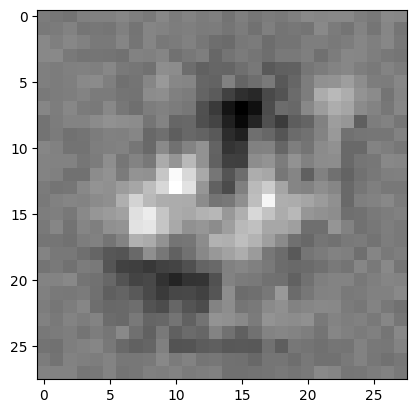

Epoch[138/200], loss: 0.22325126826763153, acc: 0.956


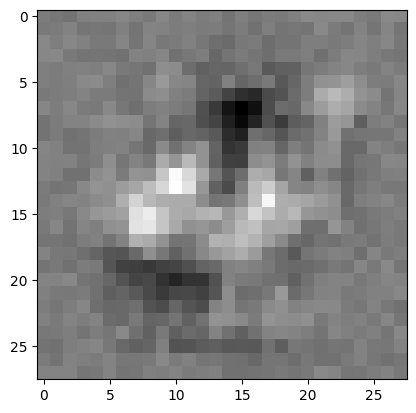

Epoch[139/200], loss: 0.22234472632408142, acc: 0.956


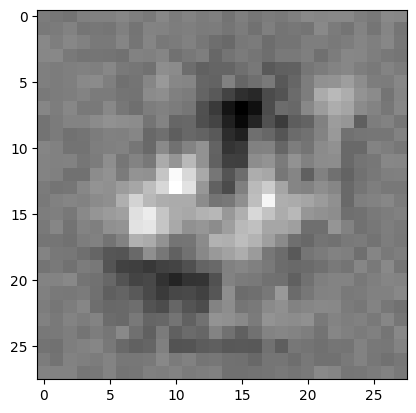

Epoch[140/200], loss: 0.22144602239131927, acc: 0.956


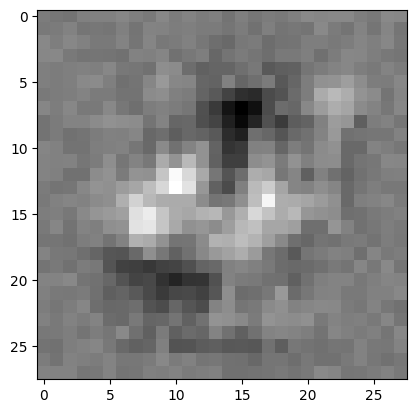

Epoch[141/200], loss: 0.22055497765541077, acc: 0.956


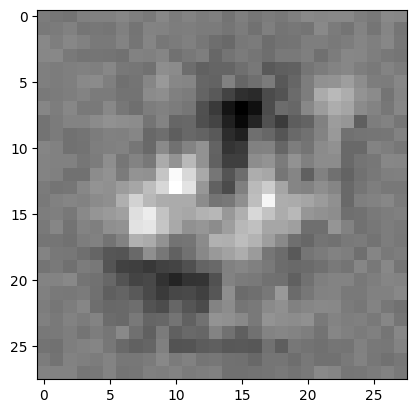

Epoch[142/200], loss: 0.21967148780822754, acc: 0.956


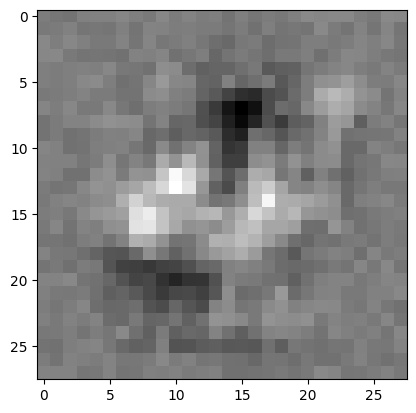

Epoch[143/200], loss: 0.21879541873931885, acc: 0.956


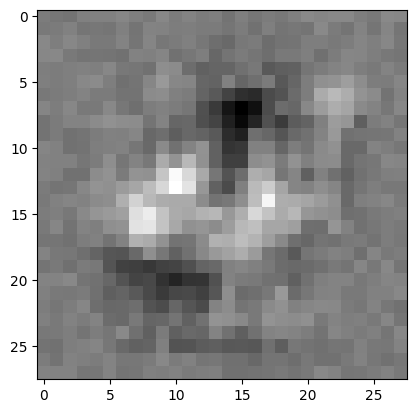

Epoch[144/200], loss: 0.21792668104171753, acc: 0.956


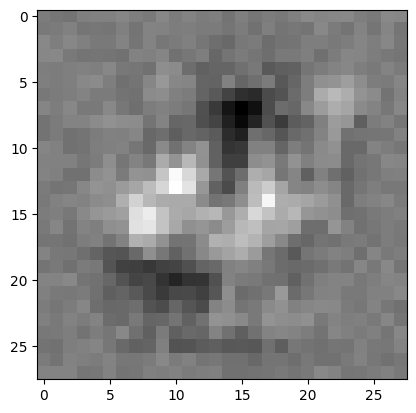

Epoch[145/200], loss: 0.21706520020961761, acc: 0.956


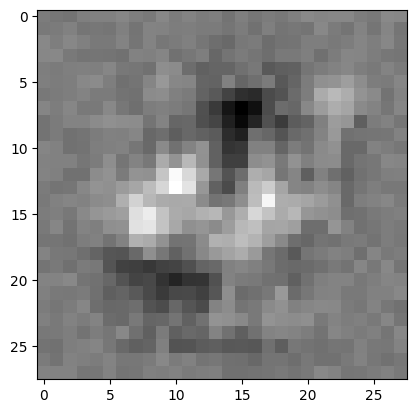

Epoch[146/200], loss: 0.21621082723140717, acc: 0.956


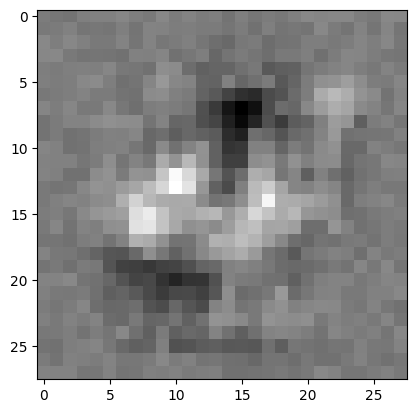

Epoch[147/200], loss: 0.21536345779895782, acc: 0.956


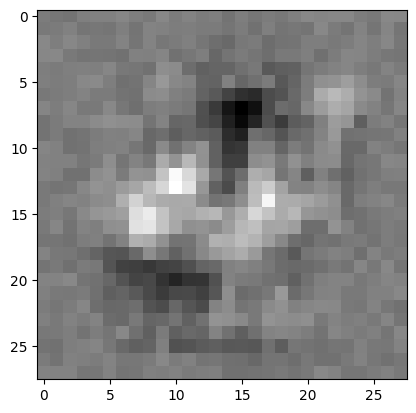

Epoch[148/200], loss: 0.21452301740646362, acc: 0.956


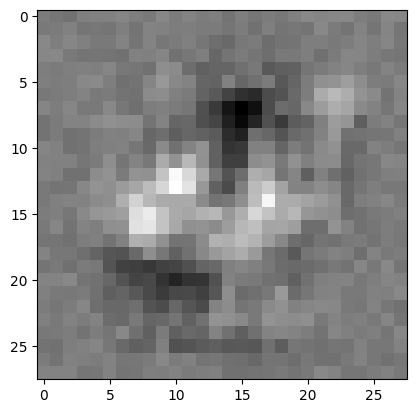

Epoch[149/200], loss: 0.213689386844635, acc: 0.956


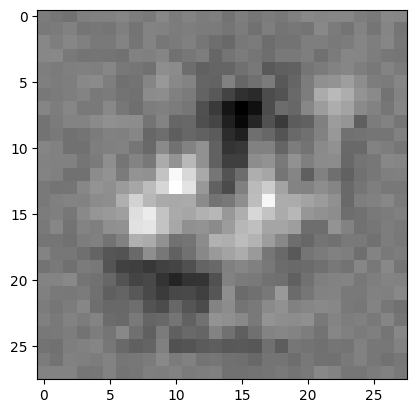

Epoch[150/200], loss: 0.21286249160766602, acc: 0.956


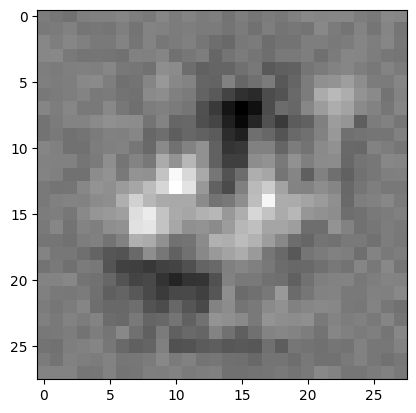

Epoch[151/200], loss: 0.2120421975851059, acc: 0.958


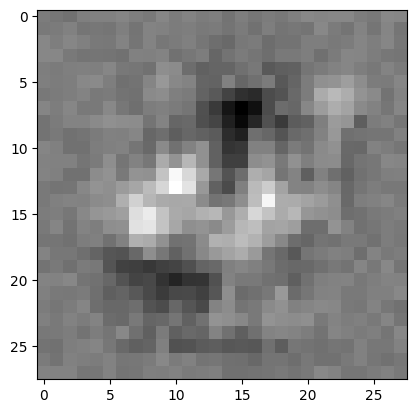

Epoch[152/200], loss: 0.21122843027114868, acc: 0.958


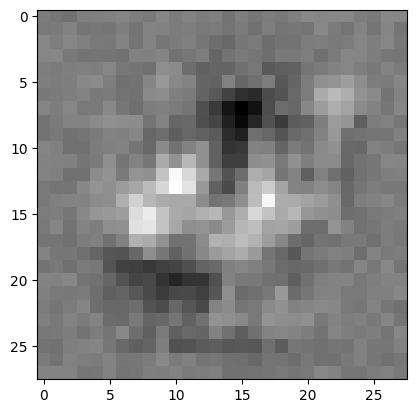

Epoch[153/200], loss: 0.2104211449623108, acc: 0.958


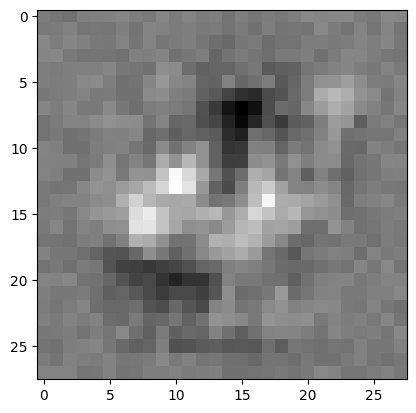

Epoch[154/200], loss: 0.2096201628446579, acc: 0.958


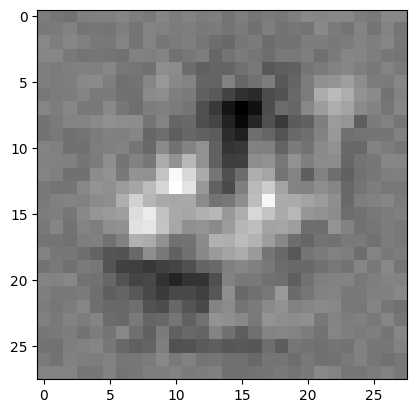

Epoch[155/200], loss: 0.20882545411586761, acc: 0.959


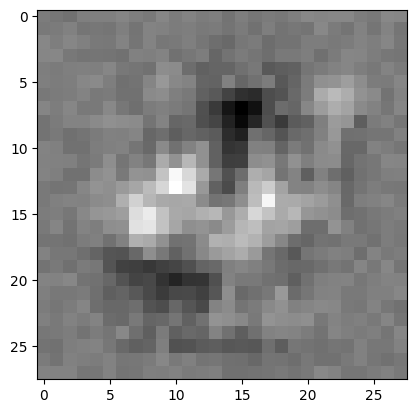

Epoch[156/200], loss: 0.20803695917129517, acc: 0.959


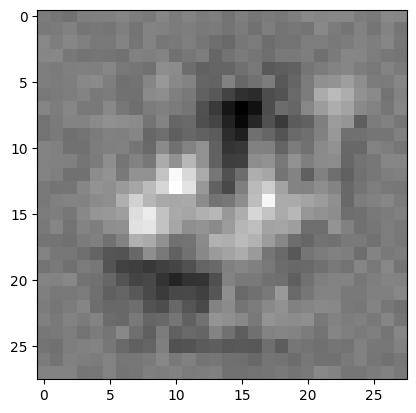

Epoch[157/200], loss: 0.2072545439004898, acc: 0.96


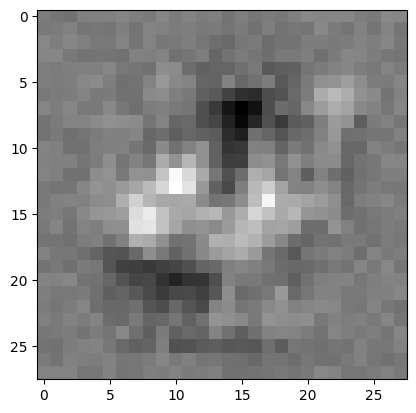

Epoch[158/200], loss: 0.20647813379764557, acc: 0.96


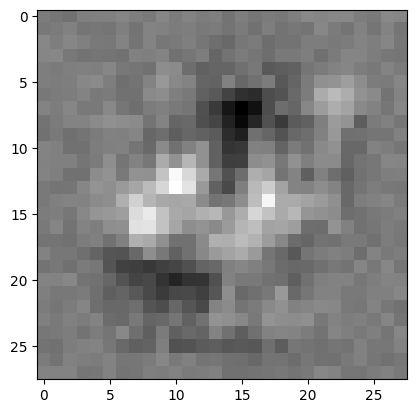

Epoch[159/200], loss: 0.20570768415927887, acc: 0.96


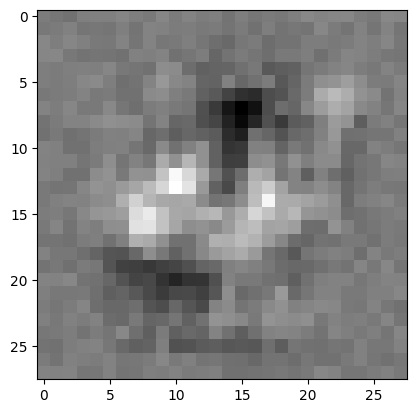

Epoch[160/200], loss: 0.20494306087493896, acc: 0.96


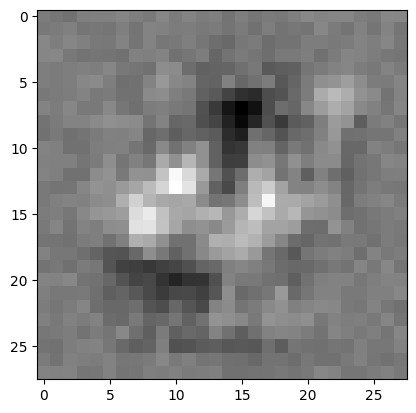

Epoch[161/200], loss: 0.20418420433998108, acc: 0.96


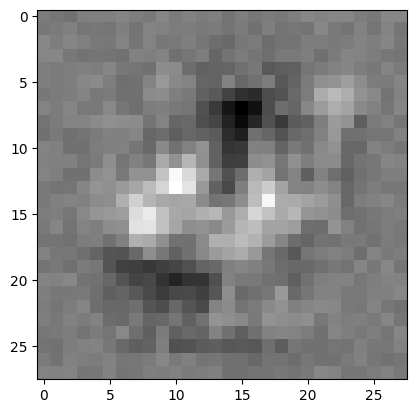

Epoch[162/200], loss: 0.2034311145544052, acc: 0.96


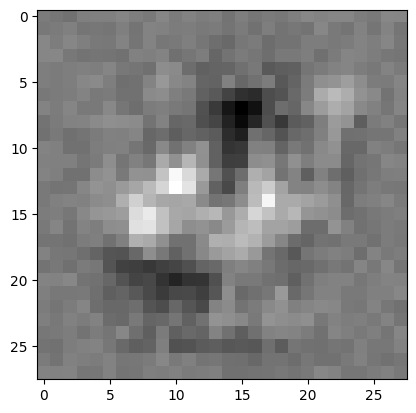

Epoch[163/200], loss: 0.20268365740776062, acc: 0.961


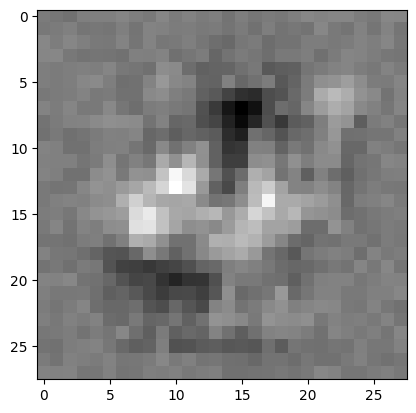

Epoch[164/200], loss: 0.20194171369075775, acc: 0.961


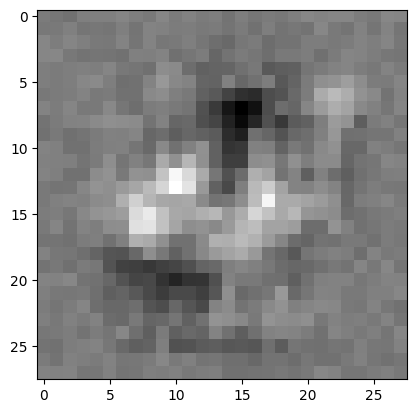

Epoch[165/200], loss: 0.201205313205719, acc: 0.961


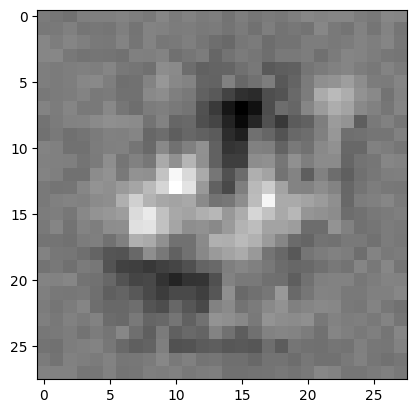

Epoch[166/200], loss: 0.20047429203987122, acc: 0.961


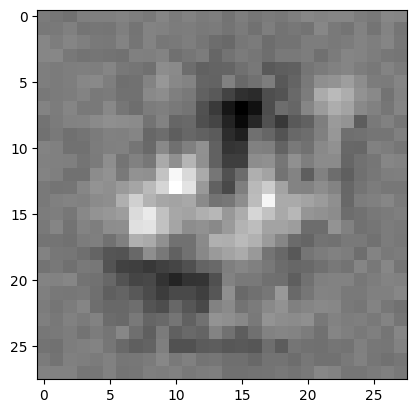

Epoch[167/200], loss: 0.19974862039089203, acc: 0.961


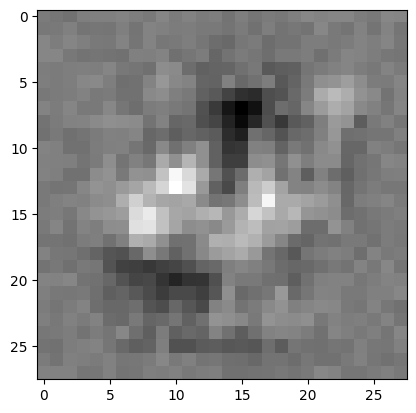

Epoch[168/200], loss: 0.19902825355529785, acc: 0.961


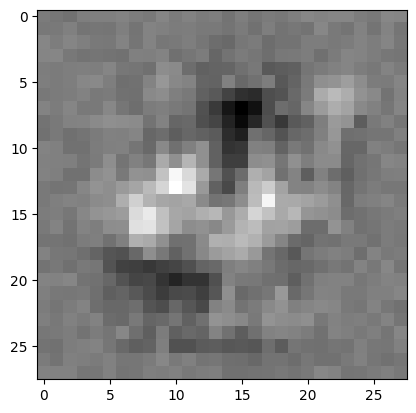

Epoch[169/200], loss: 0.19831308722496033, acc: 0.961


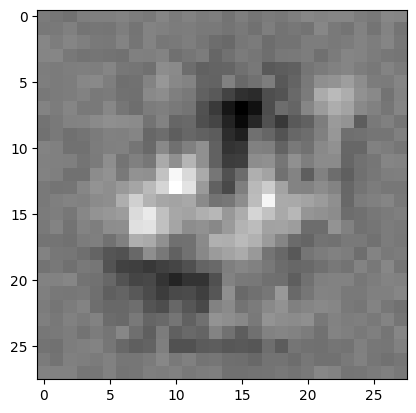

Epoch[170/200], loss: 0.19760312139987946, acc: 0.961


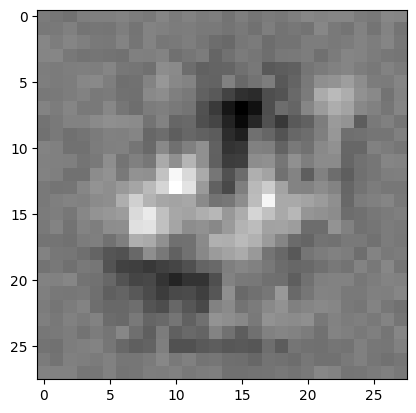

Epoch[171/200], loss: 0.1968981921672821, acc: 0.961


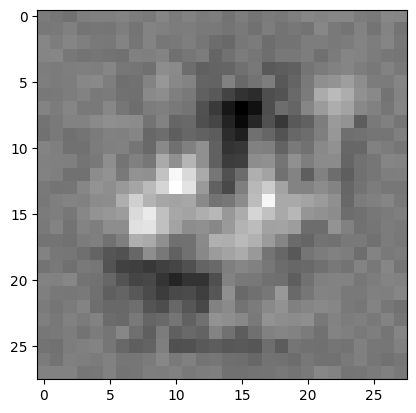

Epoch[172/200], loss: 0.19619832932949066, acc: 0.961


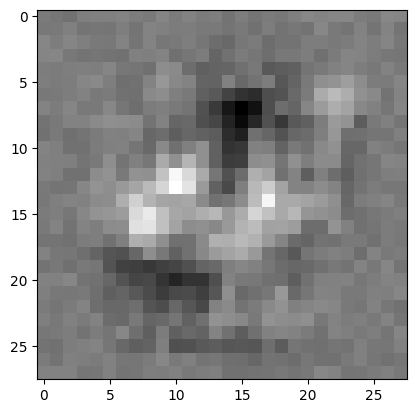

Epoch[173/200], loss: 0.19550342857837677, acc: 0.962


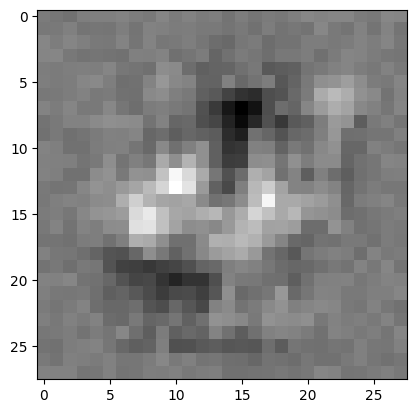

Epoch[174/200], loss: 0.19481343030929565, acc: 0.962


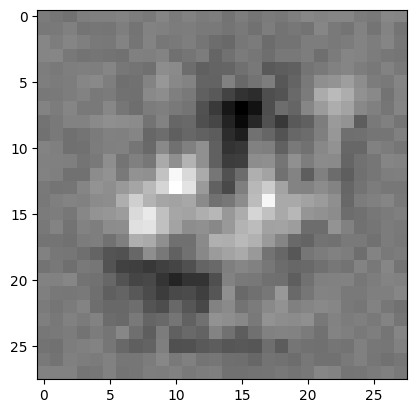

Epoch[175/200], loss: 0.19412826001644135, acc: 0.962


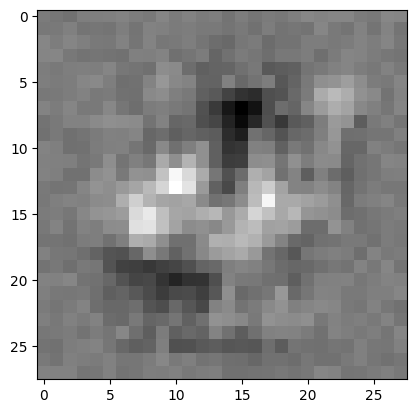

Epoch[176/200], loss: 0.19344791769981384, acc: 0.962


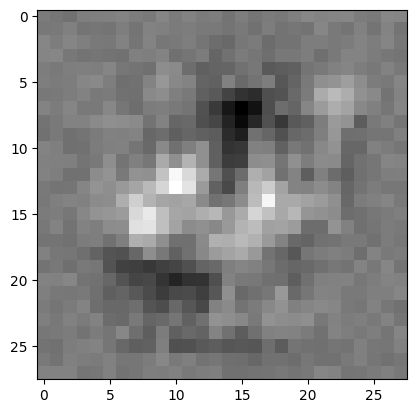

Epoch[177/200], loss: 0.1927722990512848, acc: 0.962


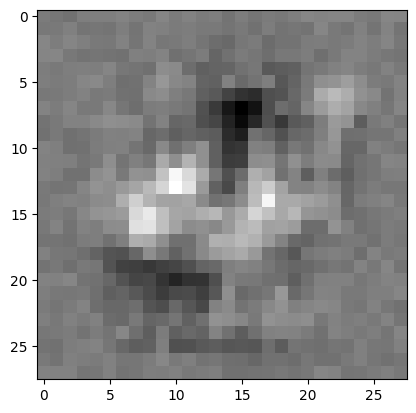

Epoch[178/200], loss: 0.1921013593673706, acc: 0.963


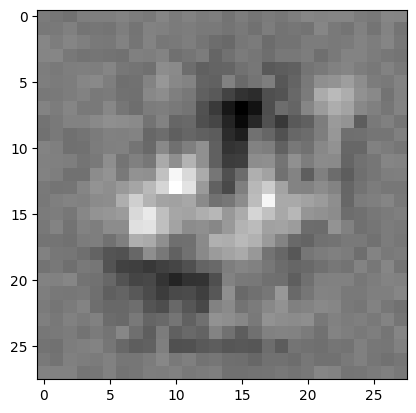

Epoch[179/200], loss: 0.1914350539445877, acc: 0.963


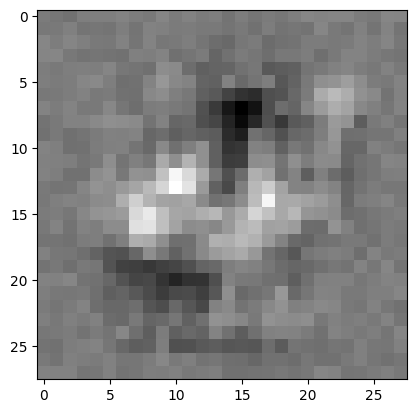

Epoch[180/200], loss: 0.19077330827713013, acc: 0.963


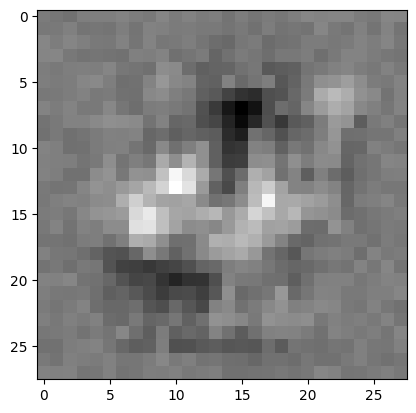

Epoch[181/200], loss: 0.19011609256267548, acc: 0.963


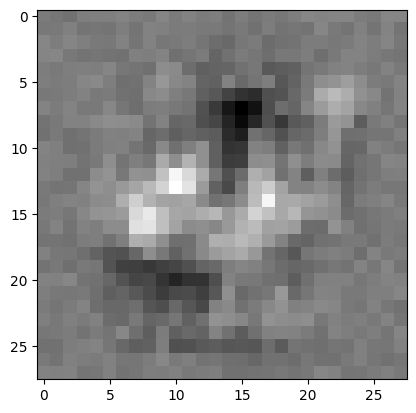

Epoch[182/200], loss: 0.18946334719657898, acc: 0.963


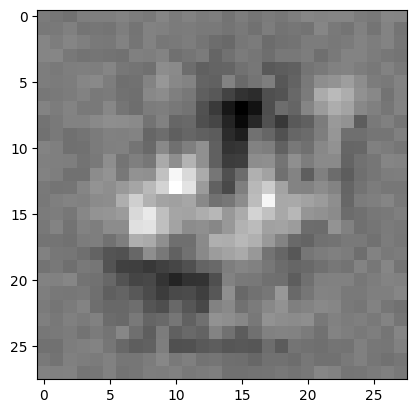

Epoch[183/200], loss: 0.18881496787071228, acc: 0.963


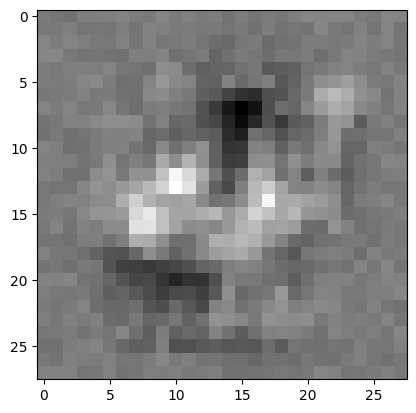

Epoch[184/200], loss: 0.18817101418972015, acc: 0.963


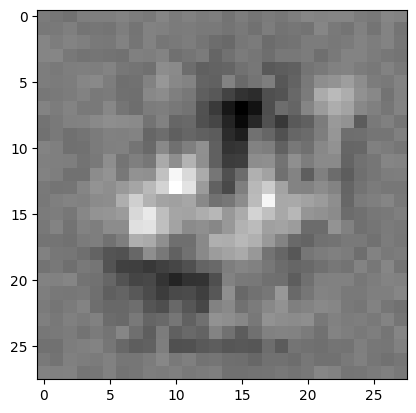

Epoch[185/200], loss: 0.18753136694431305, acc: 0.963


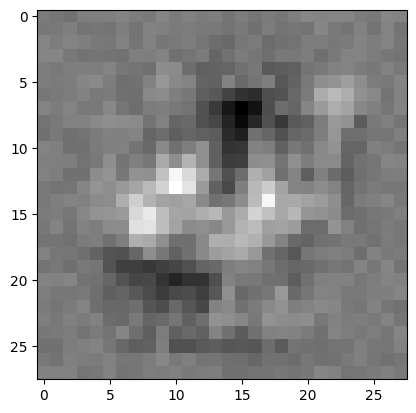

Epoch[186/200], loss: 0.18689599633216858, acc: 0.963


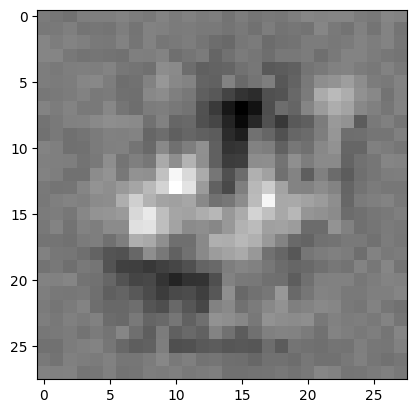

Epoch[187/200], loss: 0.18626481294631958, acc: 0.963


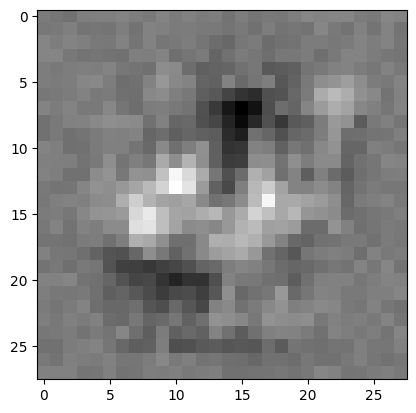

Epoch[188/200], loss: 0.18563780188560486, acc: 0.964


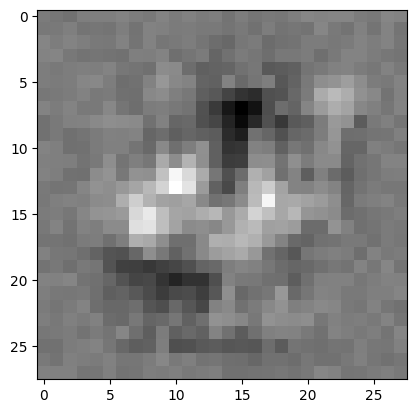

Epoch[189/200], loss: 0.18501493334770203, acc: 0.964


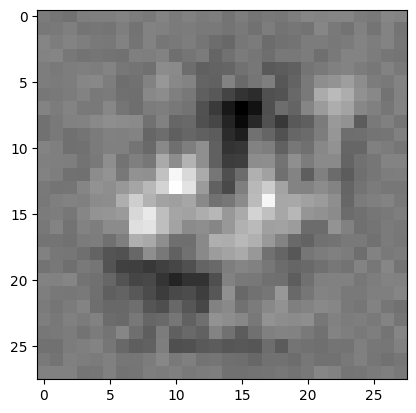

Epoch[190/200], loss: 0.1843961775302887, acc: 0.964


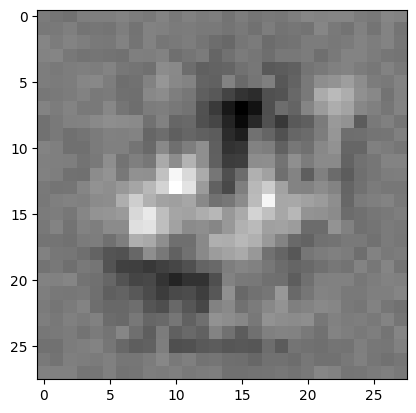

Epoch[191/200], loss: 0.18378141522407532, acc: 0.965


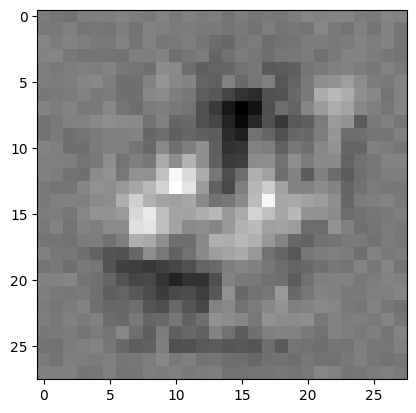

Epoch[192/200], loss: 0.18317066133022308, acc: 0.966


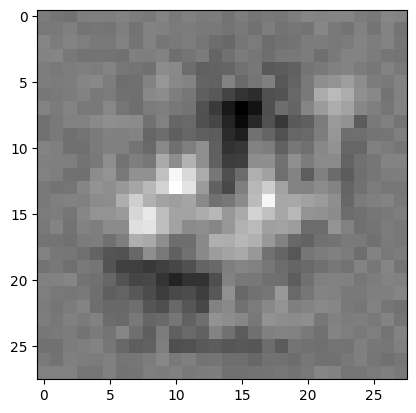

Epoch[193/200], loss: 0.18256384134292603, acc: 0.966


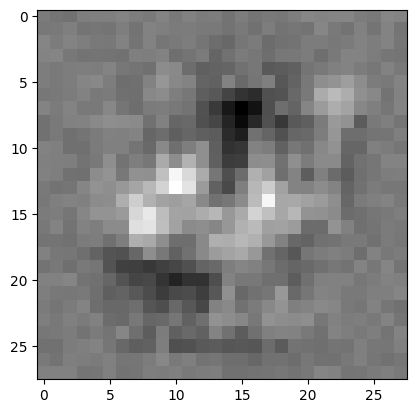

Epoch[194/200], loss: 0.18196094036102295, acc: 0.968


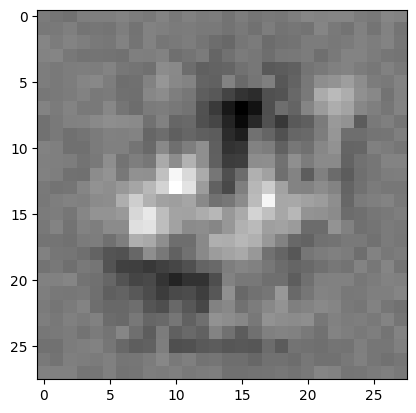

Epoch[195/200], loss: 0.18136192858219147, acc: 0.968


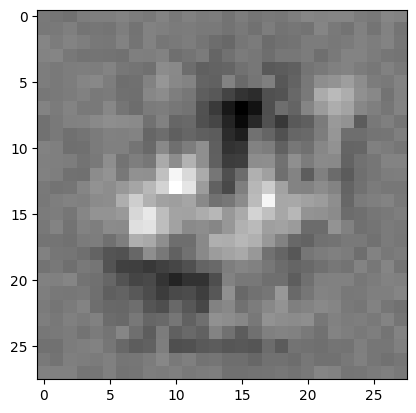

Epoch[196/200], loss: 0.18076670169830322, acc: 0.968


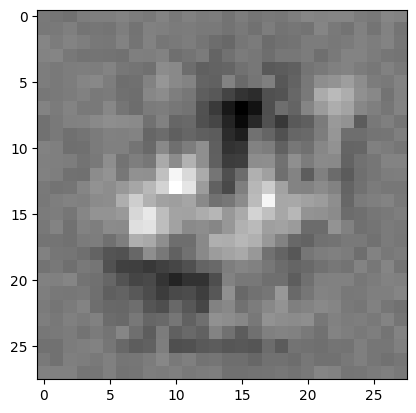

Epoch[197/200], loss: 0.18017525970935822, acc: 0.968


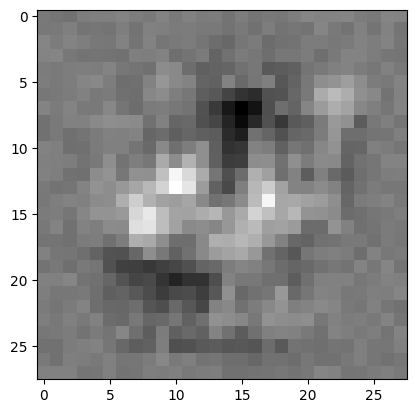

Epoch[198/200], loss: 0.17958758771419525, acc: 0.968


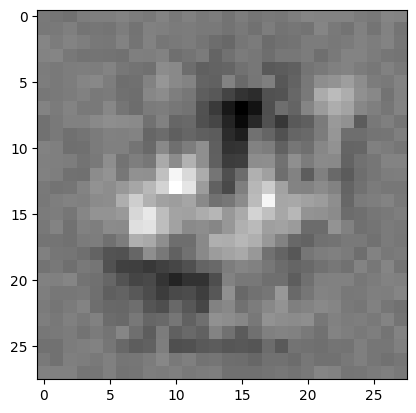

Epoch[199/200], loss: 0.17900358140468597, acc: 0.968


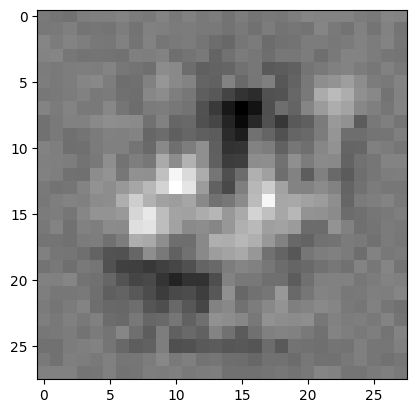

Epoch[200/200], loss: 0.17842328548431396, acc: 0.968


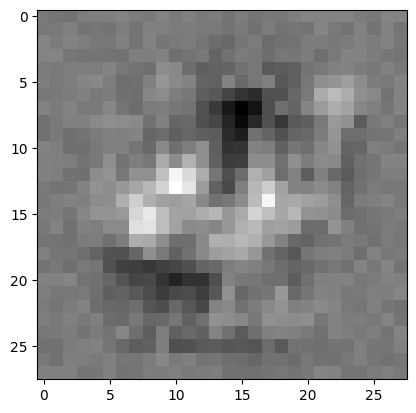

In [ ]:
model = torch.nn.Linear(28*28, 10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

inputs = Variable(x_train.view(-1, 28 * 28))
target = Variable(y_train)

epochs = 200
losses = []

for i in range(epochs):
    outputs = model(inputs)

    loss = criterion(outputs, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f'Epoch[{i+1}/{epochs}], loss: {loss.data}, acc: {accuracy}')

    model_weights = model.state_dict()['weight']

    # classe 4
    plt.imshow(model_weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

**R1 -** Entrada: [1000, 28, 28]

**R2 -** Saída: [1000, 10]

**R3 -** Os parâmetros da rede são: 784 + 10 = 794.
Onde o 784 é o resultado da multiplicação entre as dimensões da matriz de entrada 28x28.

# Aprendizados




*   Uso de RNA para processamento de imagens
*   Arquitetura de entrada de uma rede que processa imagens
*   Noção sobre o funcionamento dos filtros em camadas da rede

